In [1]:
from HeaderP import *
from __future__ import print_function
import numpy as np
import os
import scipy.io
import os.path as path
import pylab
import matplotlib
import struct
import time
import h5py
#import loaders
import sys
#from const import *
from math import *

In [71]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

#import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

In [120]:


data = pd.read_hdf('updated_rbHESTIA_17_11_127000000000003ecc.hdf5') # This one is good
#data = pd.read_hdf('rbHESTIA_17_11_127000000000003.hdf5') 
#data = pd.read_hdf('rbHESTIA_09_18_127000000000003.hdf5') 
#data = pd.read_hdf('rbHESTIA_37_11_127000000000001.hdf5') # kind of works
#data = pd.read_hdf('rbHESTIA_37_11_127000000000002.hdf5')

def calcvel(vx, vy, x, y, v0):
    R = np.sqrt(x**2+y**2)
    vr = (x * vx + y * vy)/R
    vphi = (x * vy - y * vx)/R
    ecc = np.sqrt(vr**2 + 2.*(vphi-v0)**2)/(np.sqrt(2.)*v0)
    
    return vr, vphi, ecc
len(data)

3644312

In [121]:
#data['ecc'] = np.sqrt(data.ur**2 + 2.*(data.up-250)**2)/(np.sqrt(2.)*250)


In [122]:
data.columns, len(data), max(data['age'])


(Index(['age', 'ecc', 'feh', 'mgfe', 'rb', 'up', 'ur', 'uz', 'x', 'y', 'z'], dtype='object'),
 3644312,
 13.384695053100586)

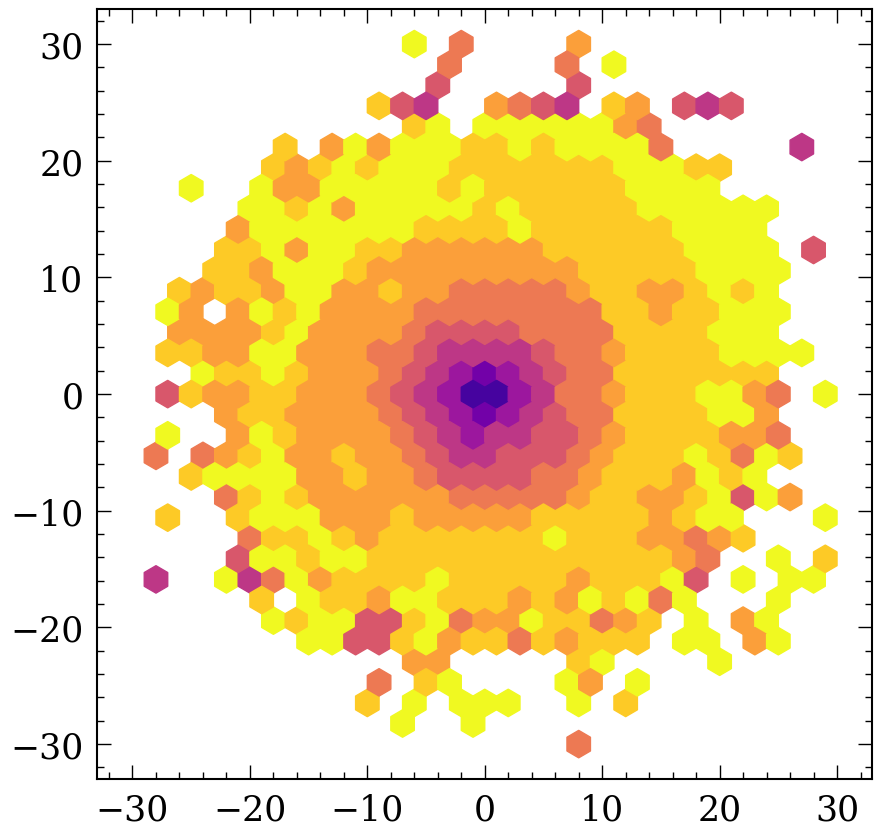

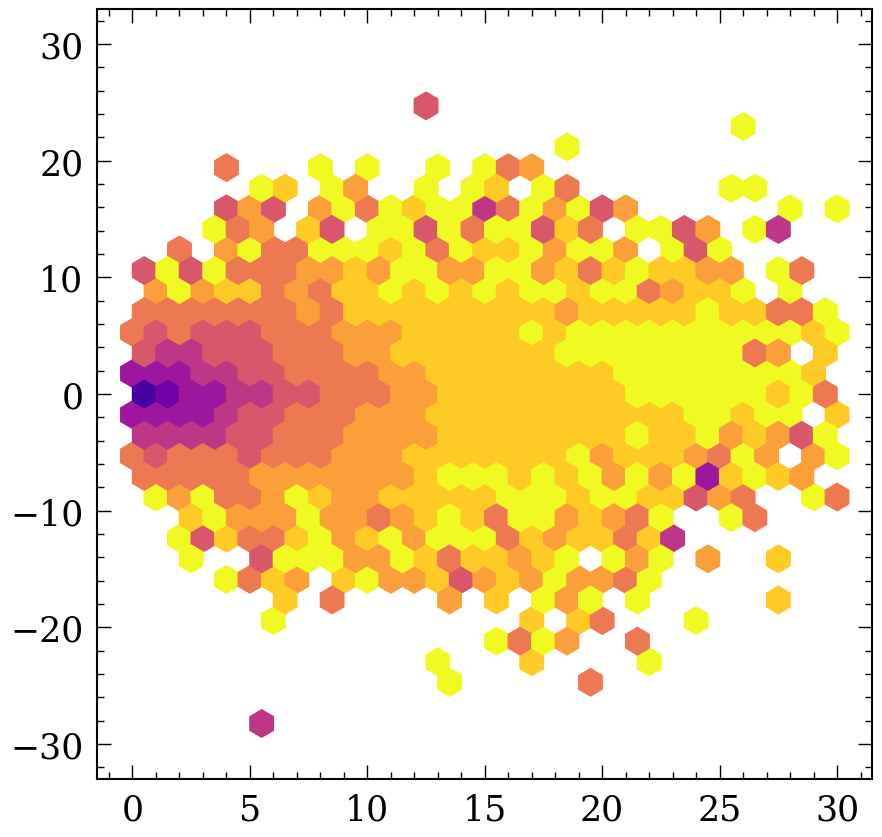

In [123]:

#data = data.loc[data['rb']<30]

rscale = 1

data['R'] = np.sqrt(data['x']**2+data['y']**2)*rscale
data['R_bir'] = data['rb']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale
data['afe'] = data['mgfe']
#data['age'] = 13.8-data['age']
#data.to_pickle('Auriga.pkl')

plt.figure()
plt.hexbin(data['x'], data['y'], C=abs(data['R_bir']),
          extent=(-30,30,-30,30),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))


plt.figure()
plt.hexbin(data['R'], data['z'], C=abs(data['R_bir']),
          extent=(0,30,-30,30),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))


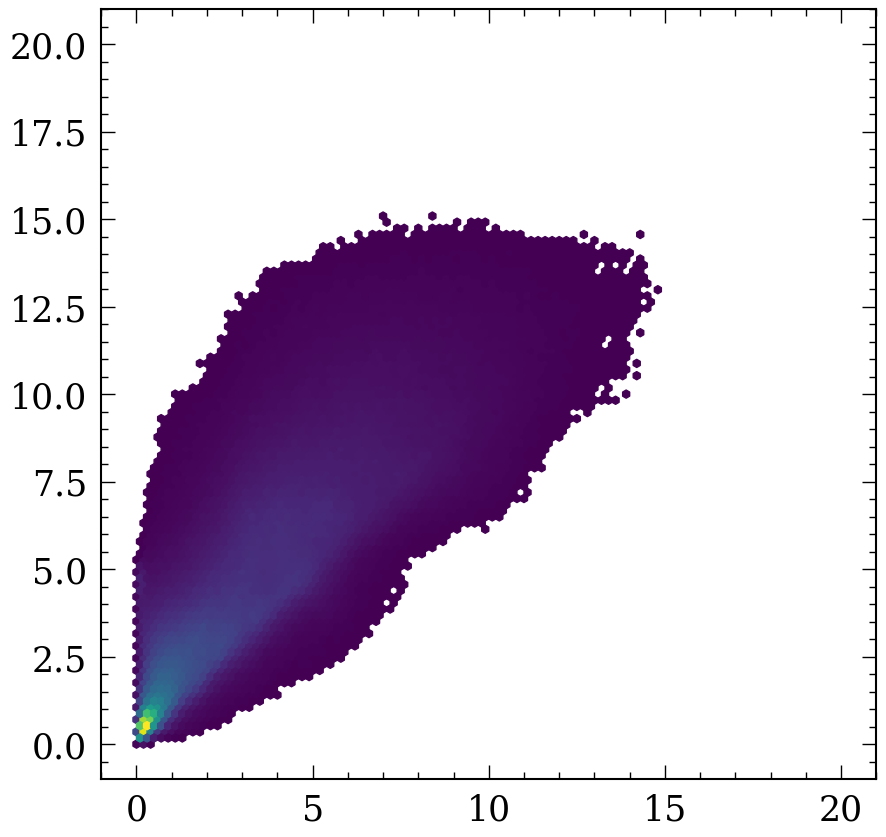

In [124]:

plt.hexbin(data['R'], data['R_bir'], 
          extent=(0,20,0,20), mincnt=100)



In [125]:
"""plt.figure()
plt.hexbin(data['feh'], data['afe'], extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)

plt.figure()
plt.hexbin(data['feh'], data['afe'], C=data['age'], 
           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)

plt.figure()
plt.hexbin(data['feh'], data['afe'], C=data['R_bir'], 
           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)

"""

"plt.figure()\nplt.hexbin(data['feh'], data['afe'], extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)\n\nplt.figure()\nplt.hexbin(data['feh'], data['afe'], C=data['age'], \n           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)\n\nplt.figure()\nplt.hexbin(data['feh'], data['afe'], C=data['R_bir'], \n           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)\n\n"

In [126]:
#m = ((data['age']-10)<0.5)&(((data['feh']+0.4)<0.1))
#plt.hist(data['R'][m],bins=np.linspace(0,10,100))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


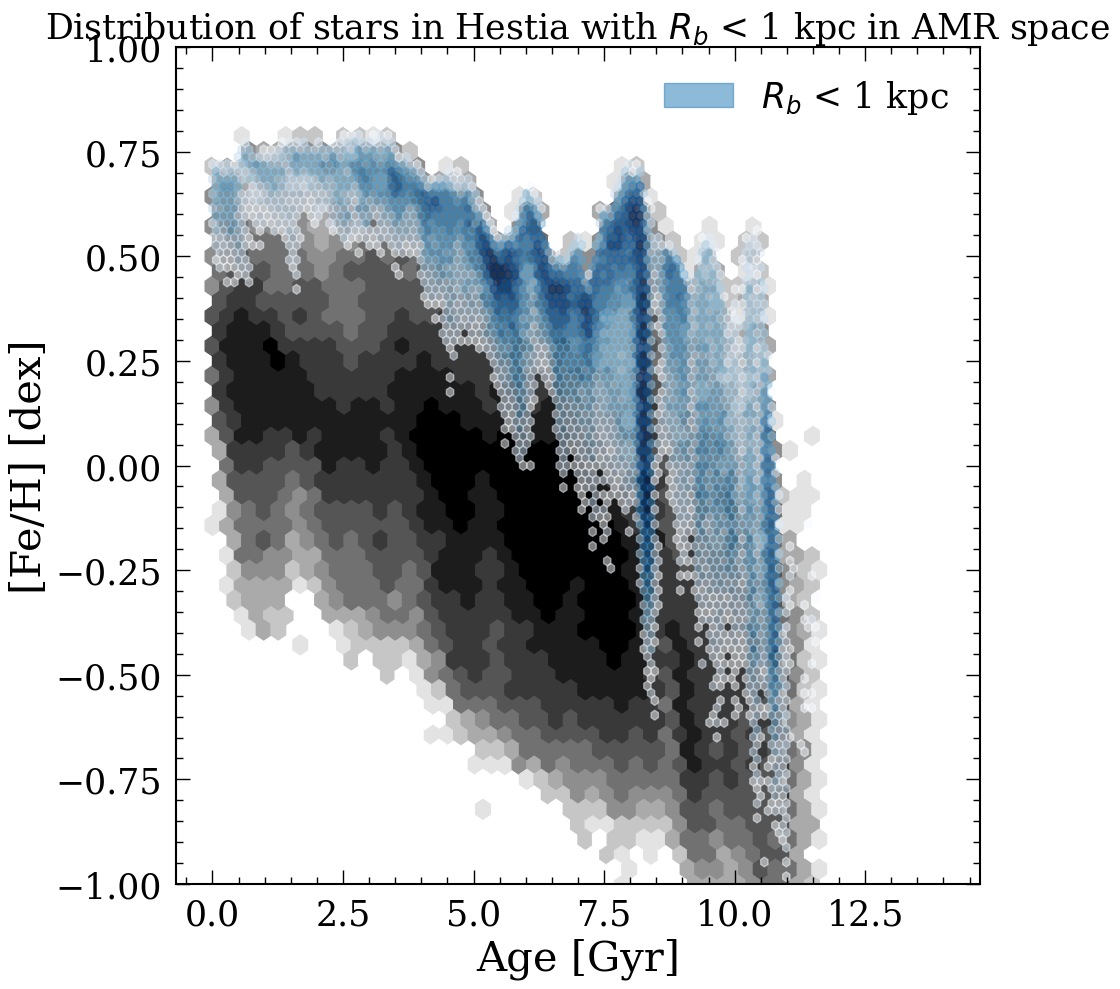

In [127]:
"""plt.figure()
plt.hexbin(data['age'], data['feh'], 
          extent=(0,14,-1,1),mincnt=1)"""


plt.figure()
m = (data['R']<4)&(data['ecc']<0.2)
plt.hexbin(data['age'][m], data['feh'][m], 
          extent=(0,14,-1,1),mincnt=1,
           gridsize=50,cmap=plt.get_cmap('binary',10),
          bins='log')

m = (data['R_bir']<1)&(data['z']<0.1)
plt.hexbin(data['age'][m], data['feh'][m], 
           cmap=plt.get_cmap('Blues',10), mincnt=10,
          extent=(0,14,-1,1),bins='log',label='$R_b$ < 1 kpc',
          alpha=0.5)
plt.ylim([-1,1])
plt.legend()
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.title('Distribution of stars in Hestia with $R_b$ < 1 kpc in AMR space', fontsize=25)
plt.tight_layout()
plt.savefig('AddFig/highres/Hestia_rb1')
plt.savefig('AddFig/Hestia_rb1.png')




# Check simiulation with a bar

In [128]:
print(len(data))
data = data.loc[data['R_bir']<30]
data = data.loc[data['age']>=0]
print(len(data))

3644312
3639952


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

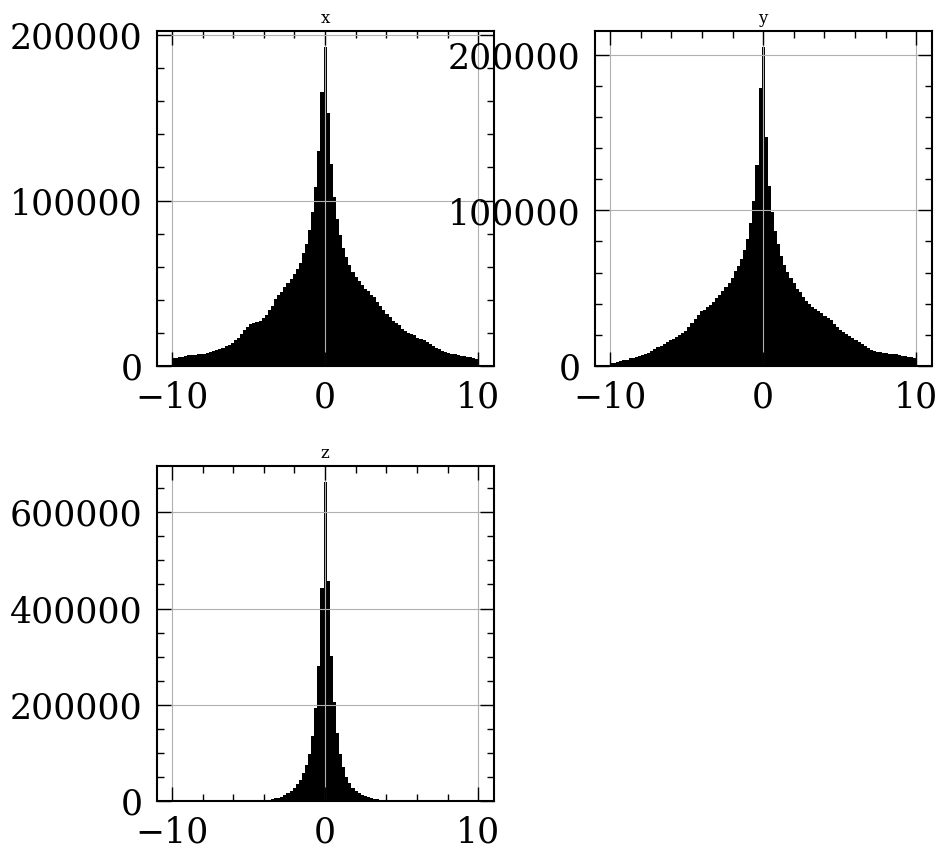

In [129]:

data[['x','y','z']].hist(bins=np.linspace(-10,10,100),
                        color='k')


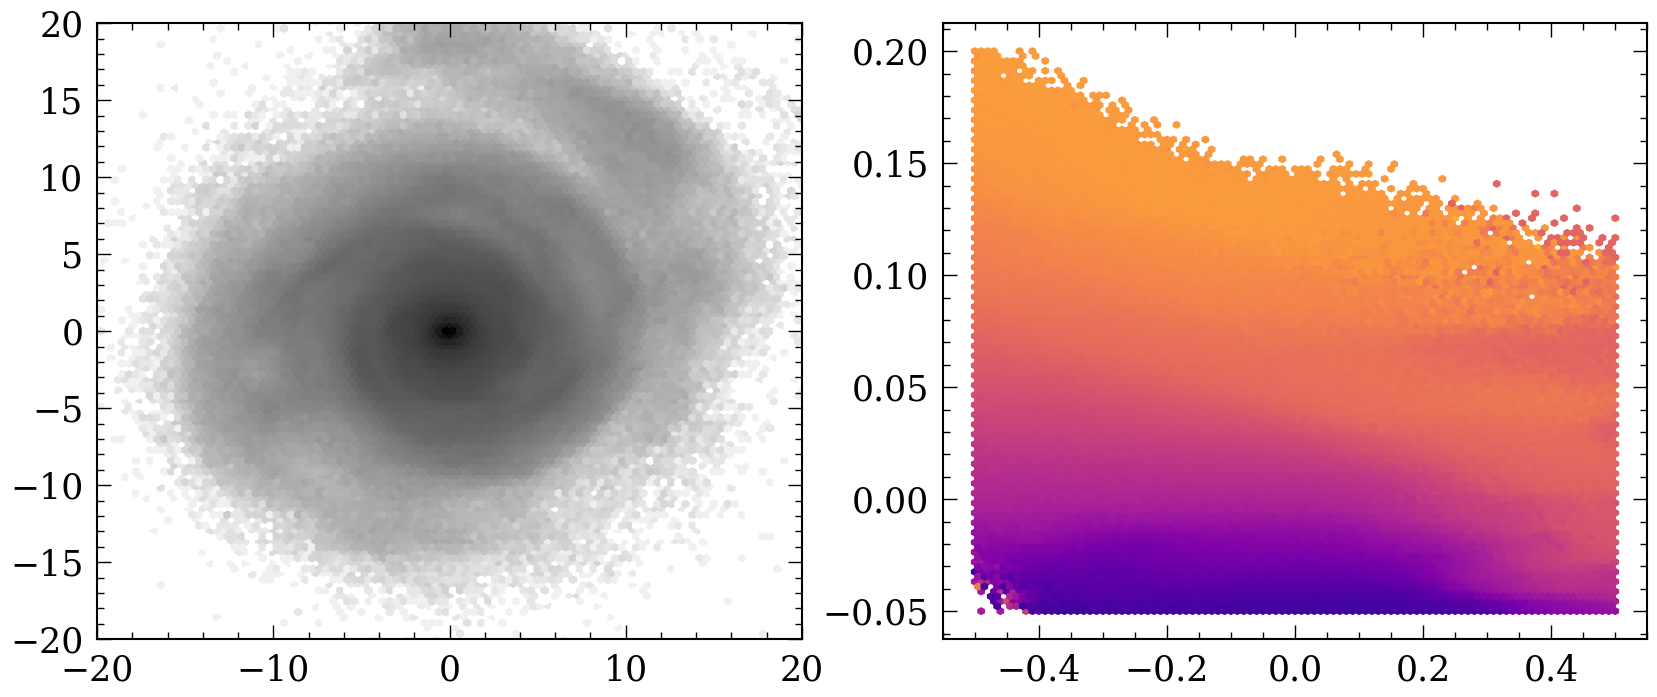

In [130]:

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['x'], data['y'], extent=(-20,20,-20,20),
          cmap='binary', bins='log')
plt.xlim([-20,20])
plt.ylim([-20,20])

plt.subplot(1,2,2)
plt.hexbin(data['feh'], data['afe'], C = data['age'],
           extent=(-0.5, 0.5, -0.05, 0.2),
          cmap='plasma', vmin=0, vmax=14)


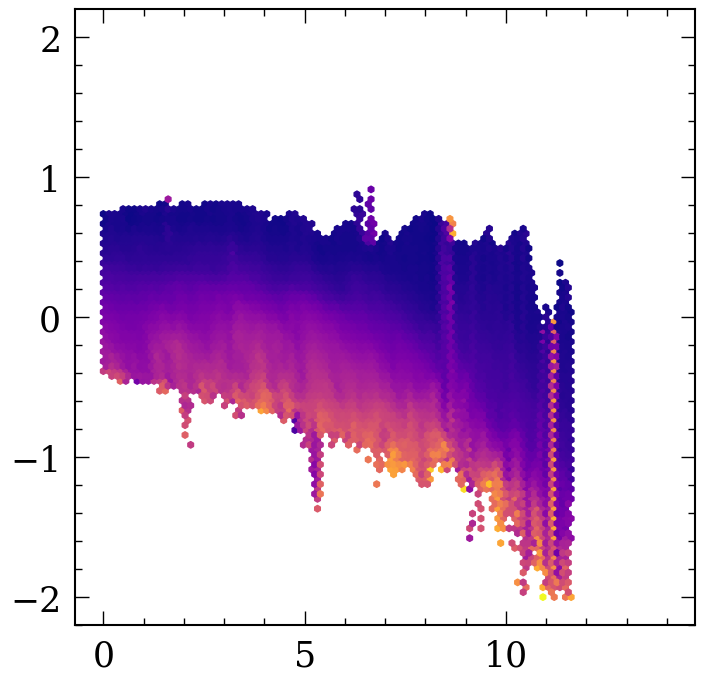

In [131]:
plt.figure(figsize=(8,8))
plt.hexbin(data['age'], data['feh'], C=data['R_bir'],
           extent=(0,14,-2,2),
          mincnt=1, cmap='plasma')

  0%|                                                    | 0/41 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 49%|████████████████████▉                      | 20/41 [00:05<00:05,  3.84it/s]/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_54220/1849834335.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,8))
100%|█████████████████████████████████████████████| 2/2 [00:06<00:00,  3.31s/it]


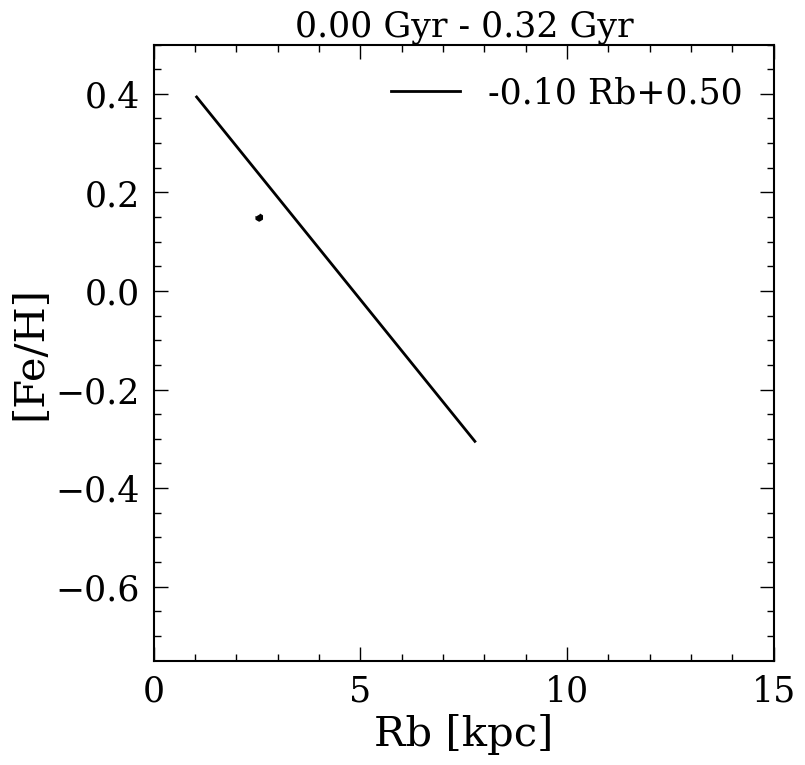

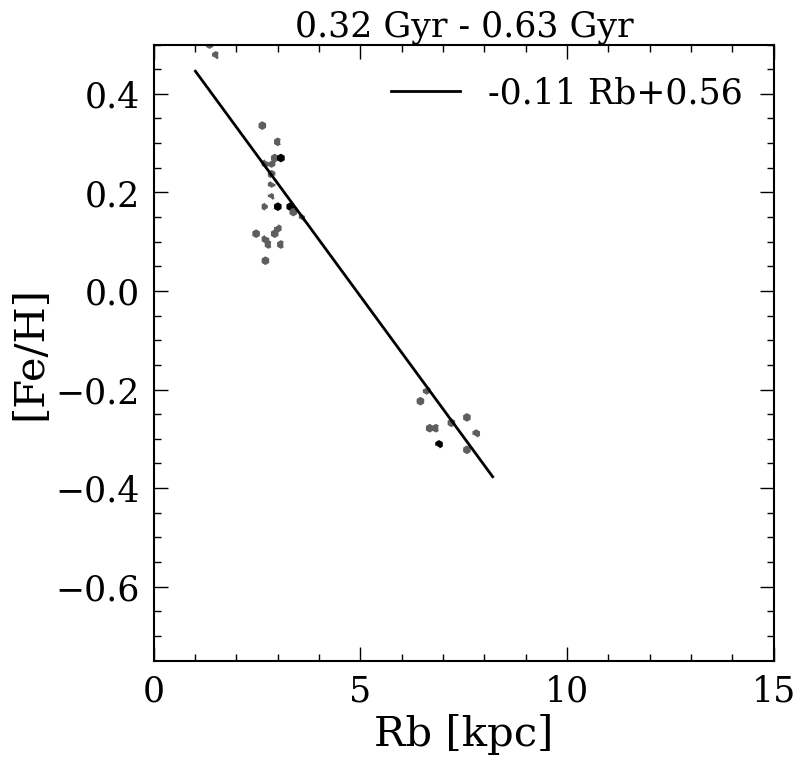

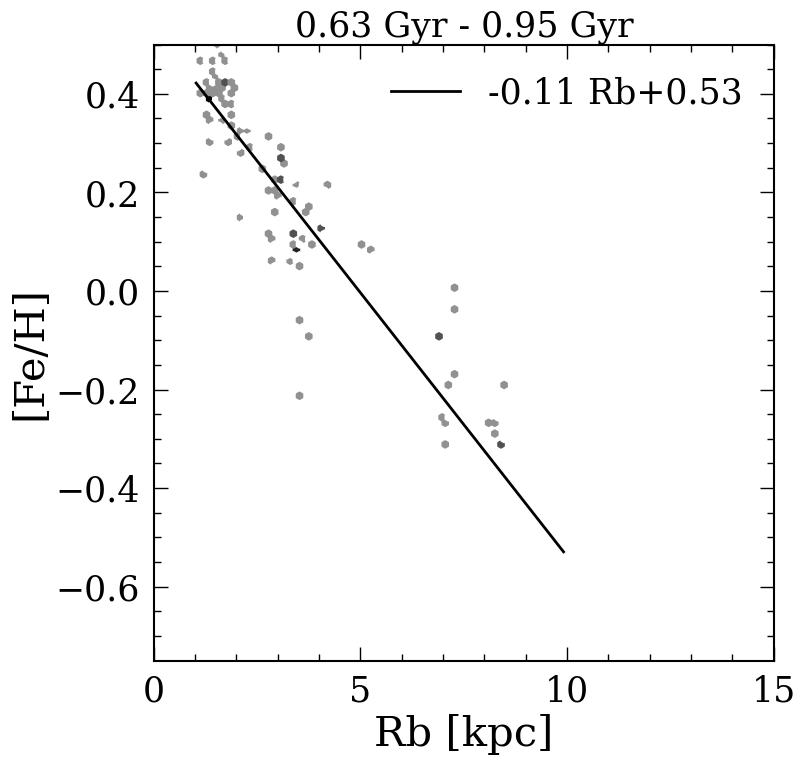

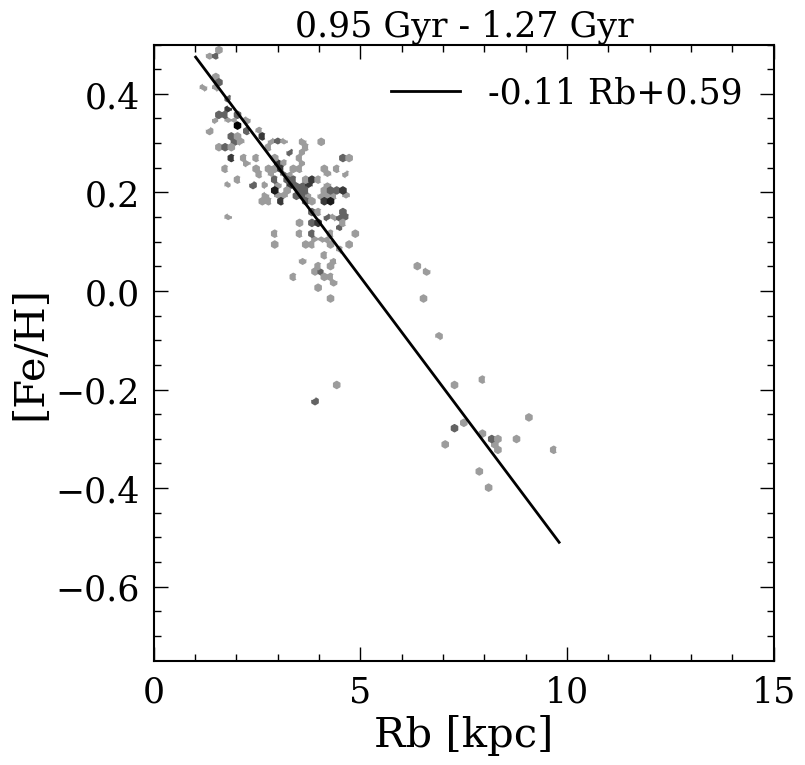

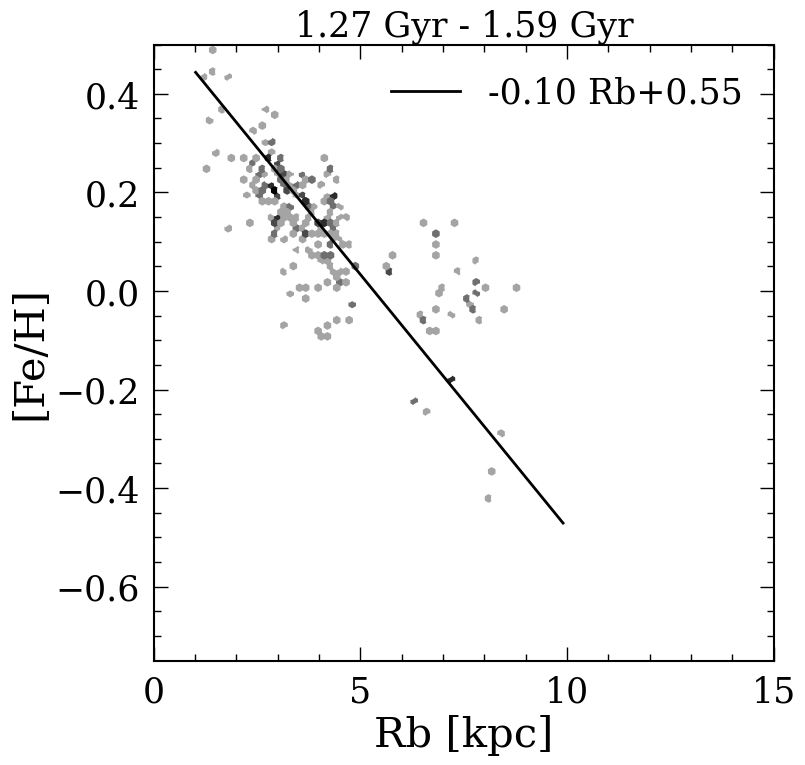

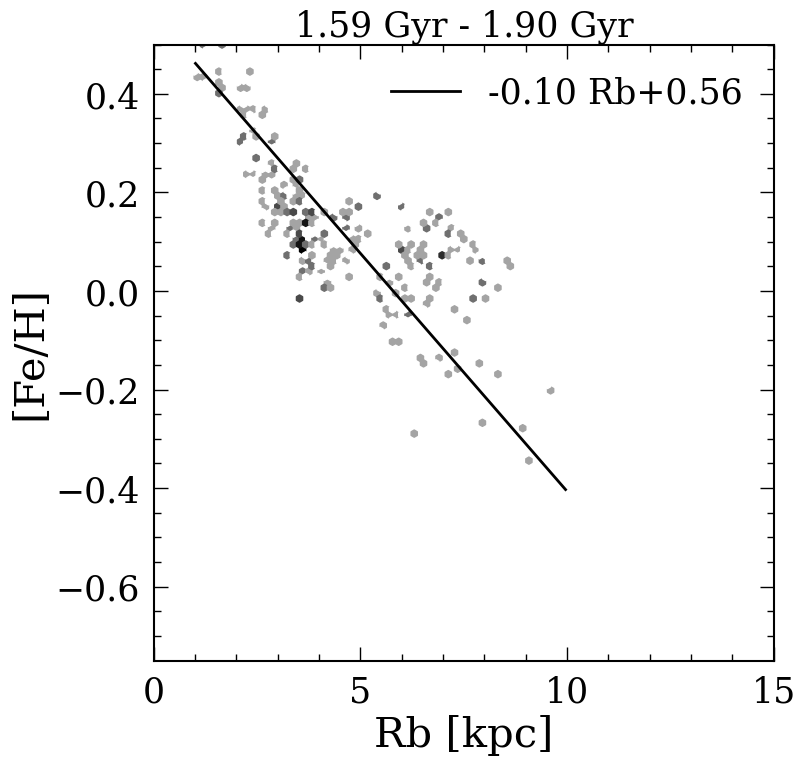

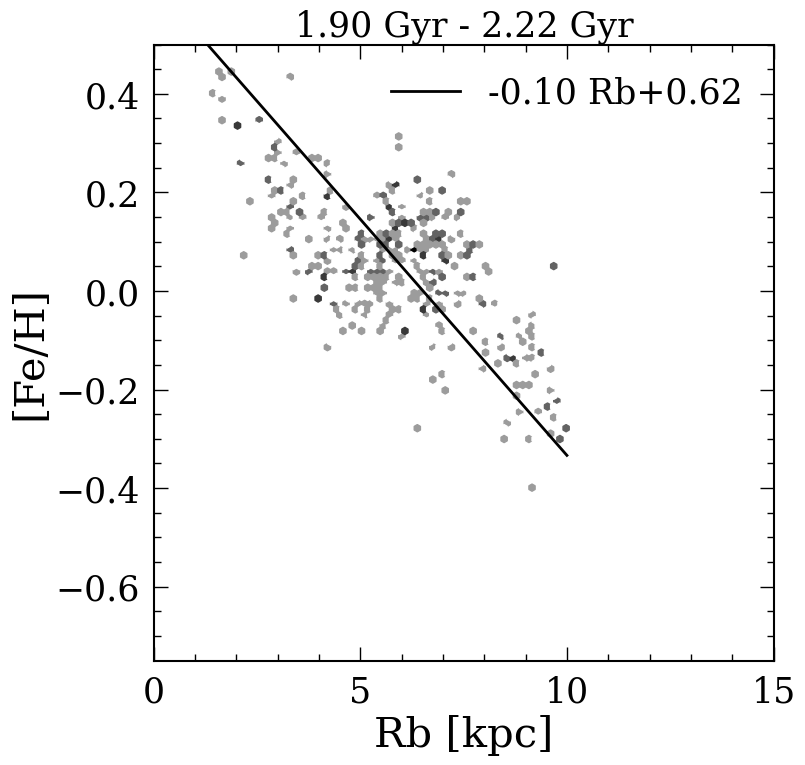

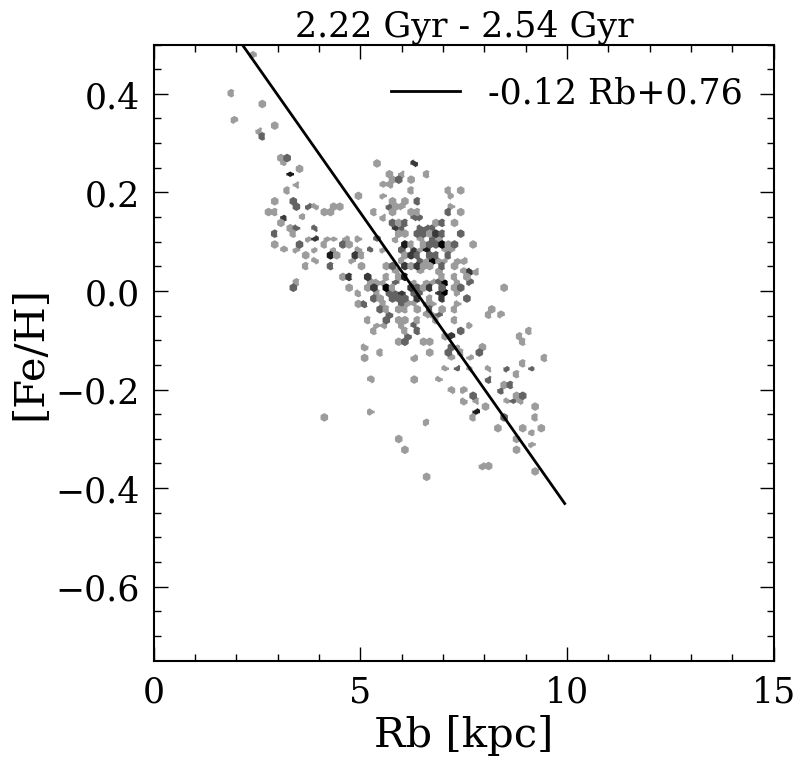

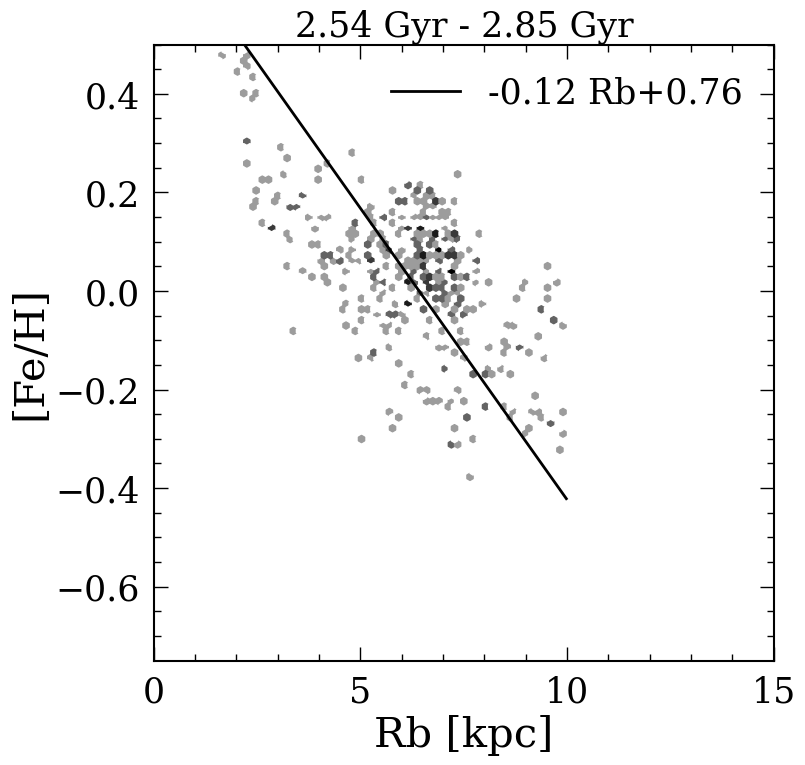

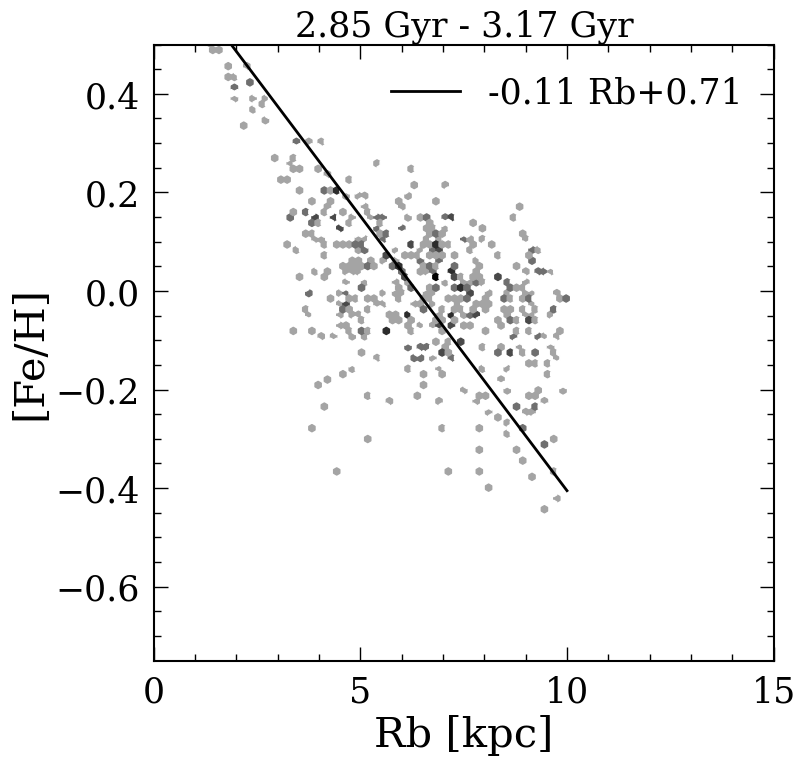

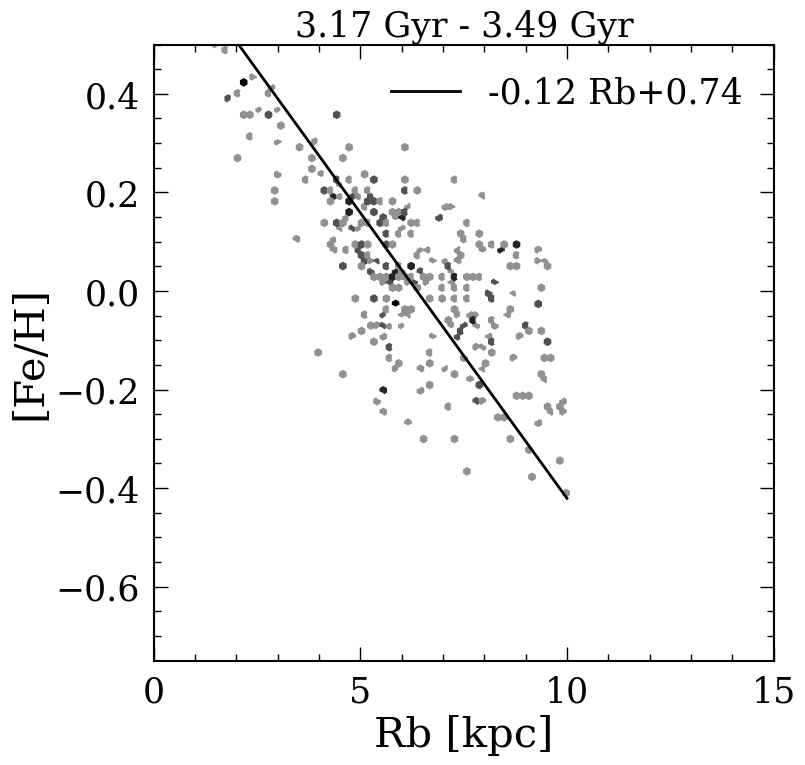

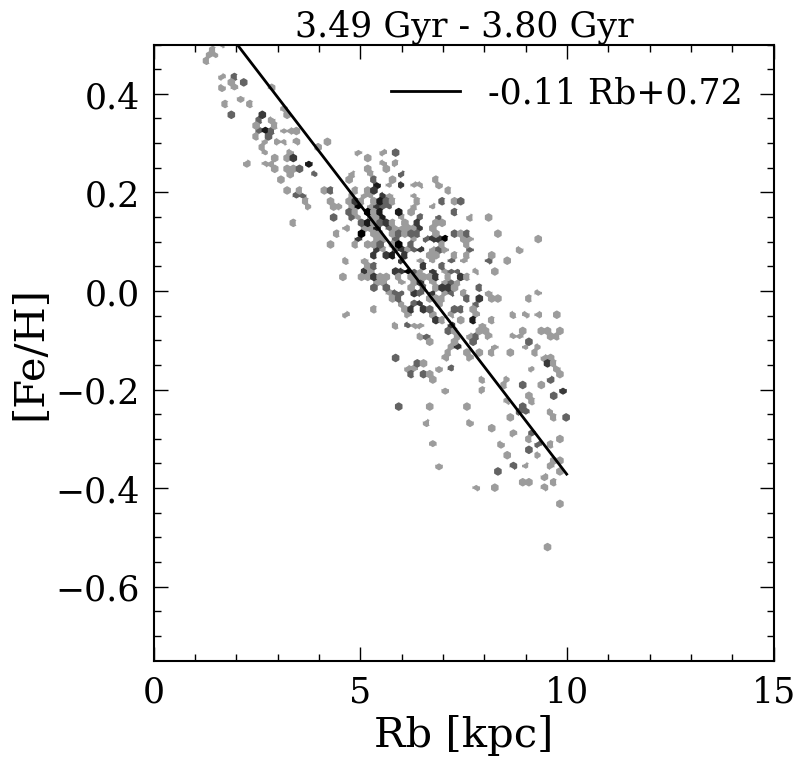

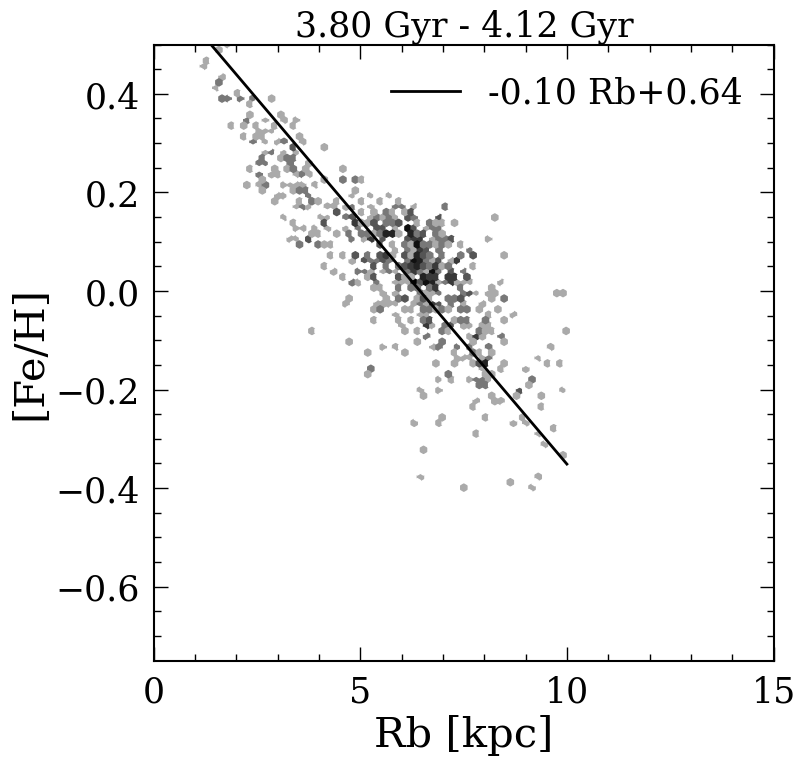

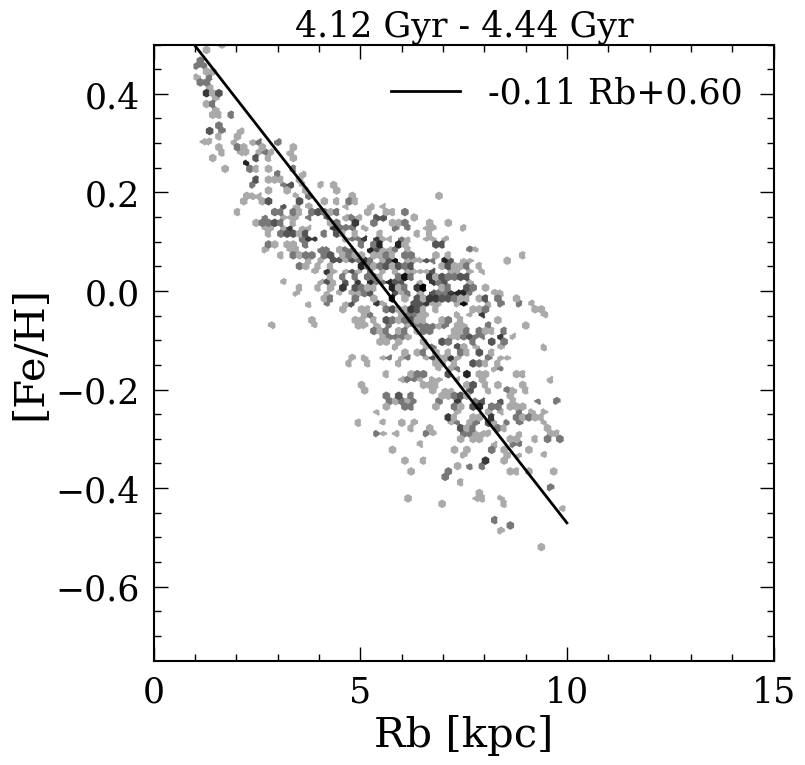

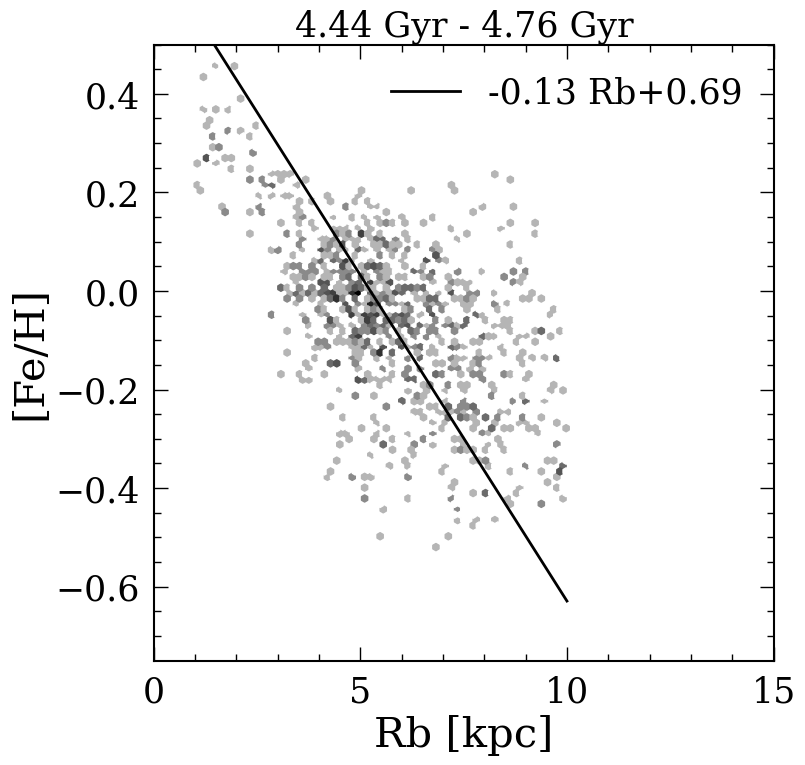

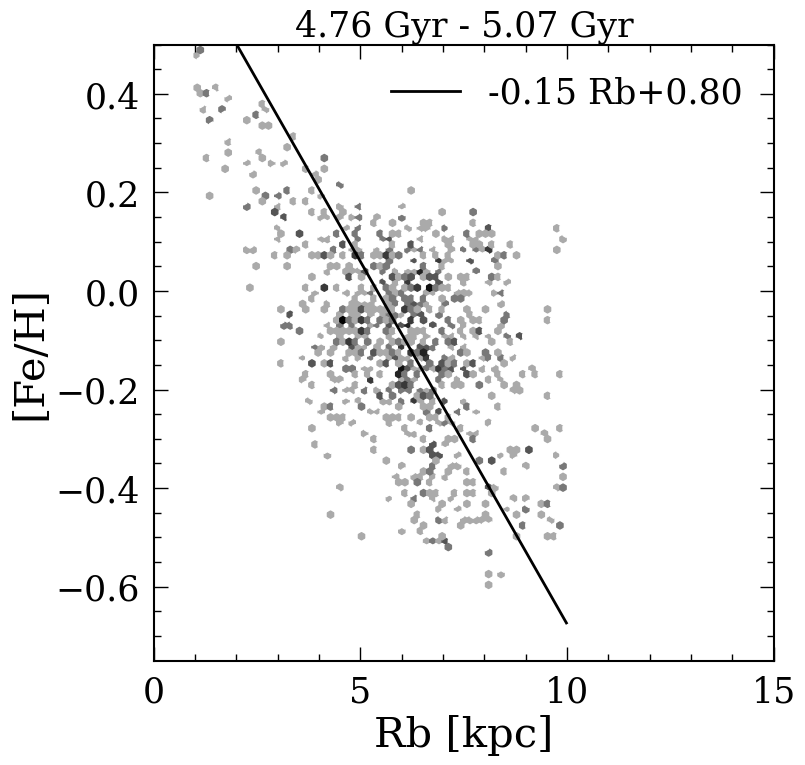

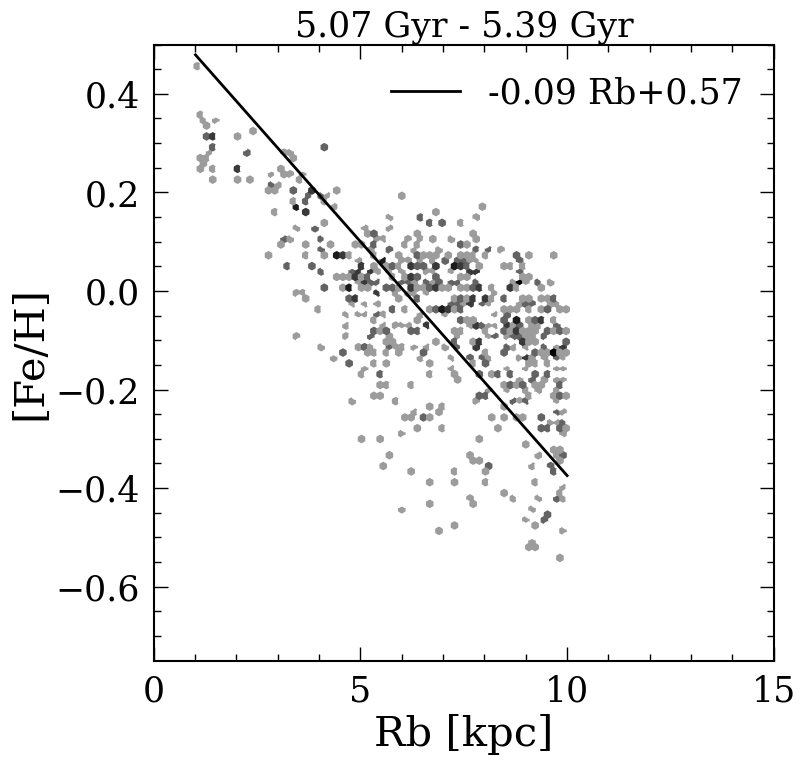

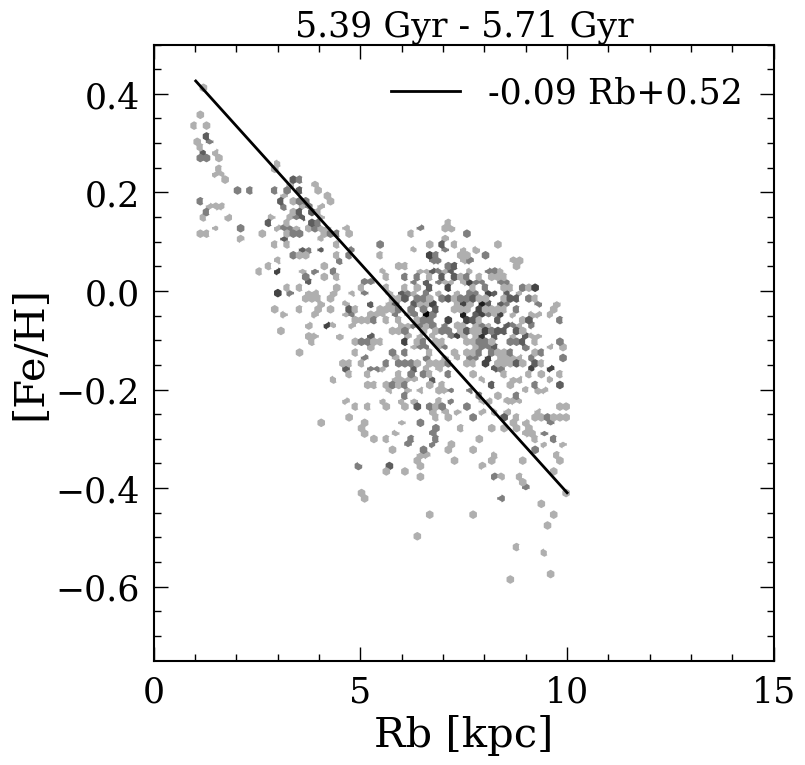

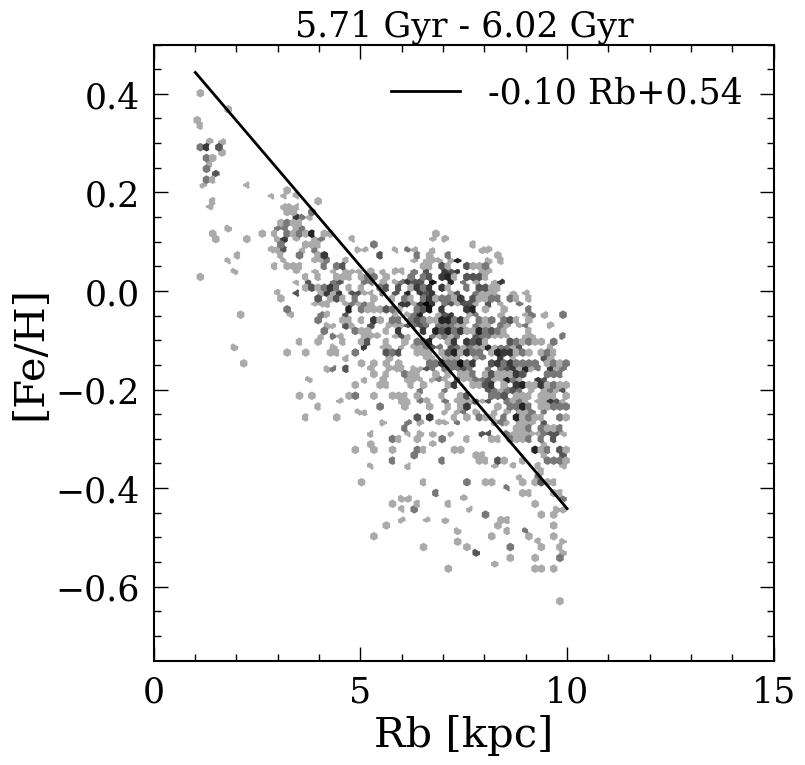

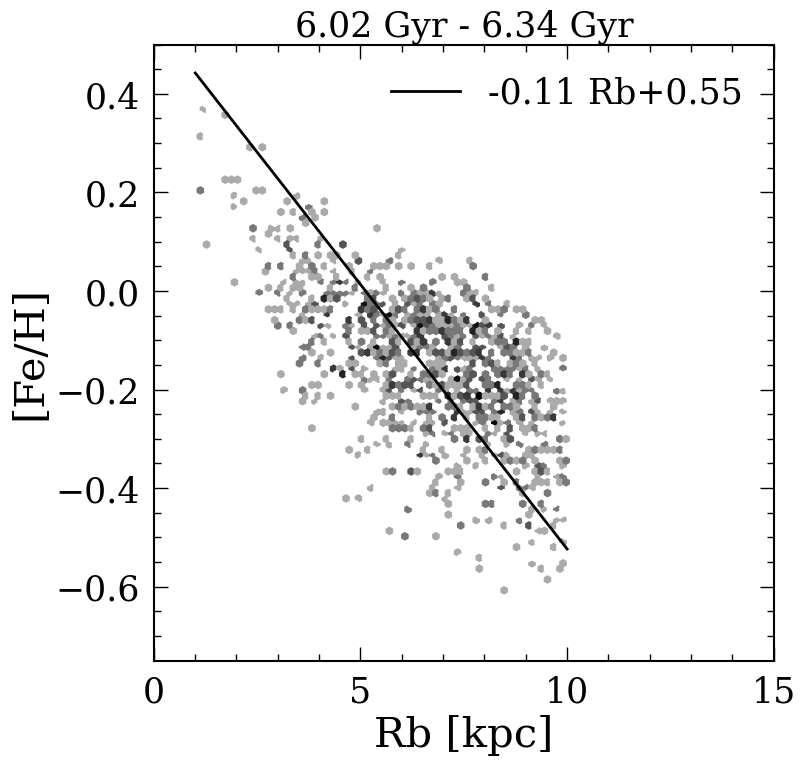

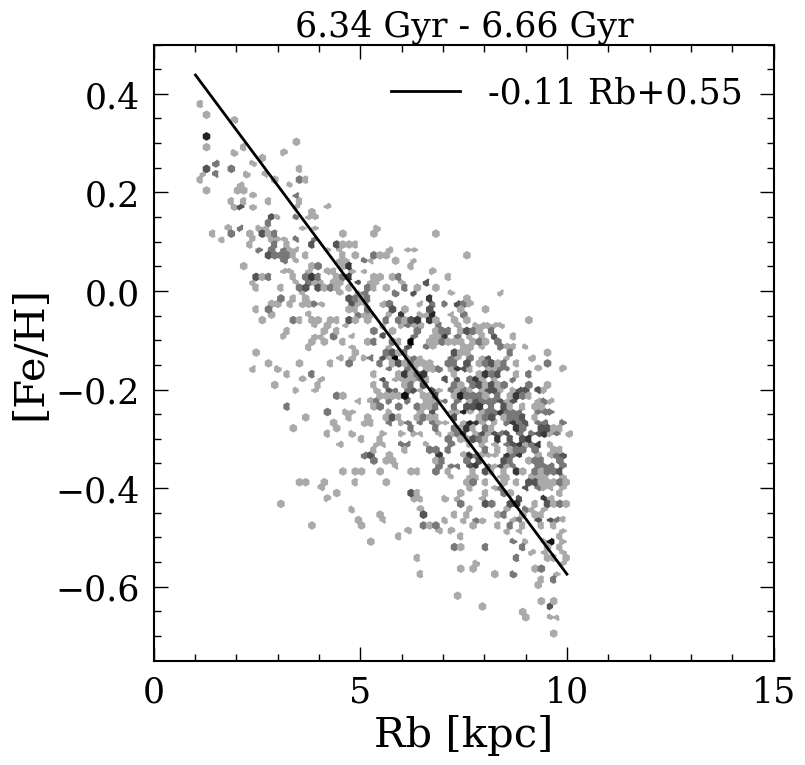

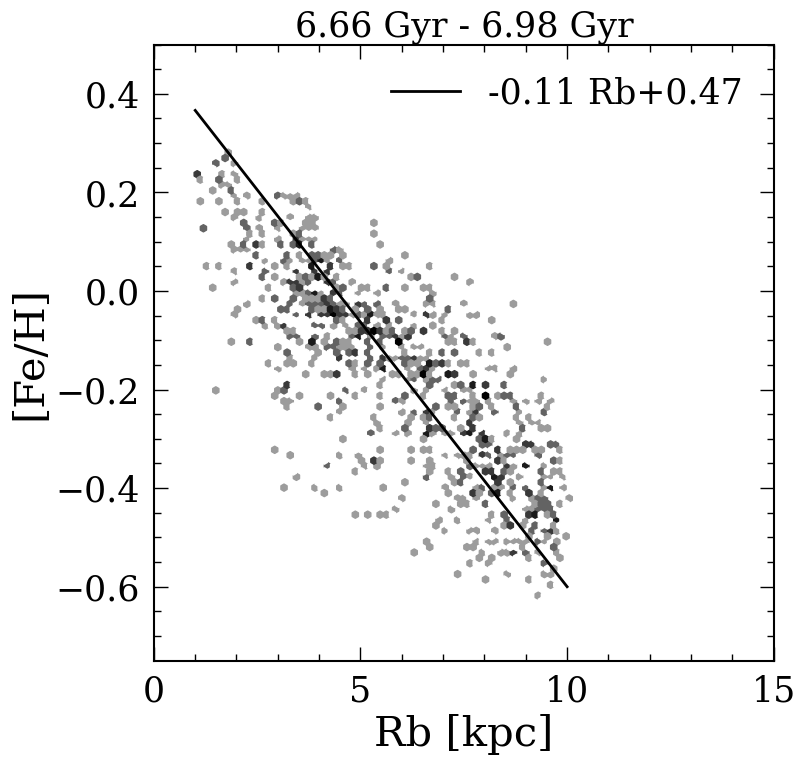

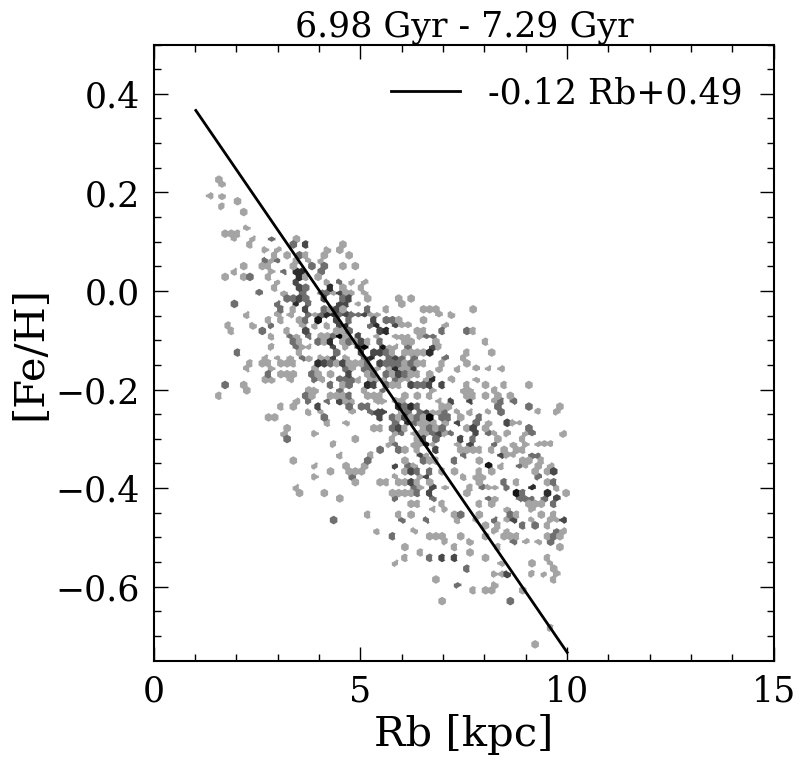

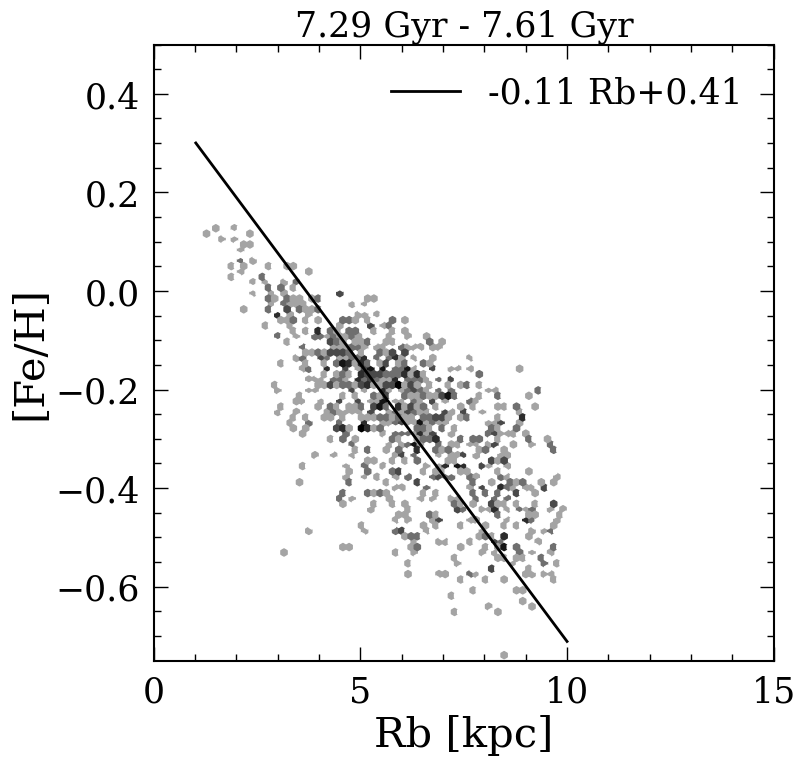

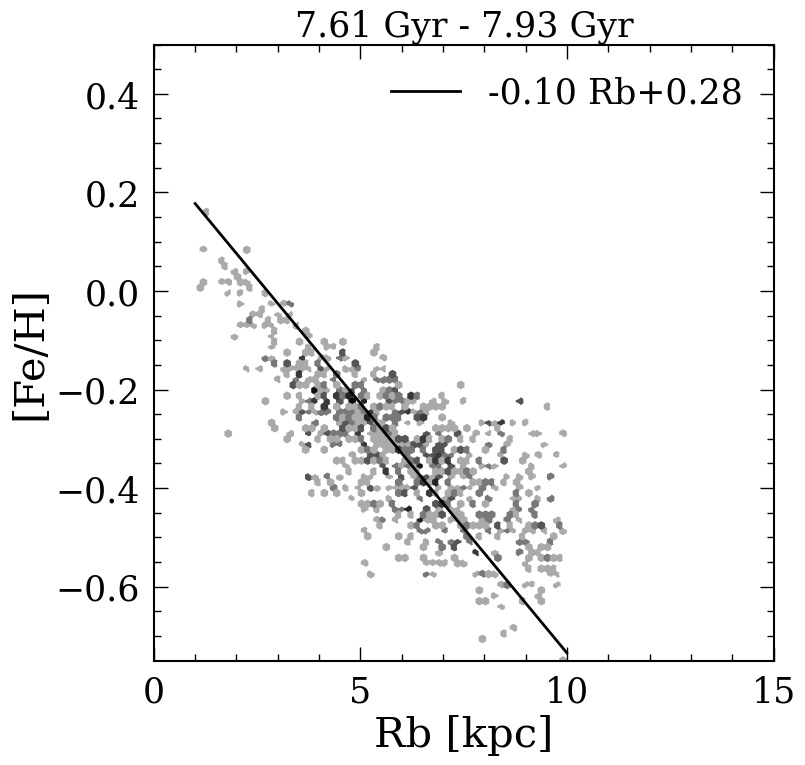

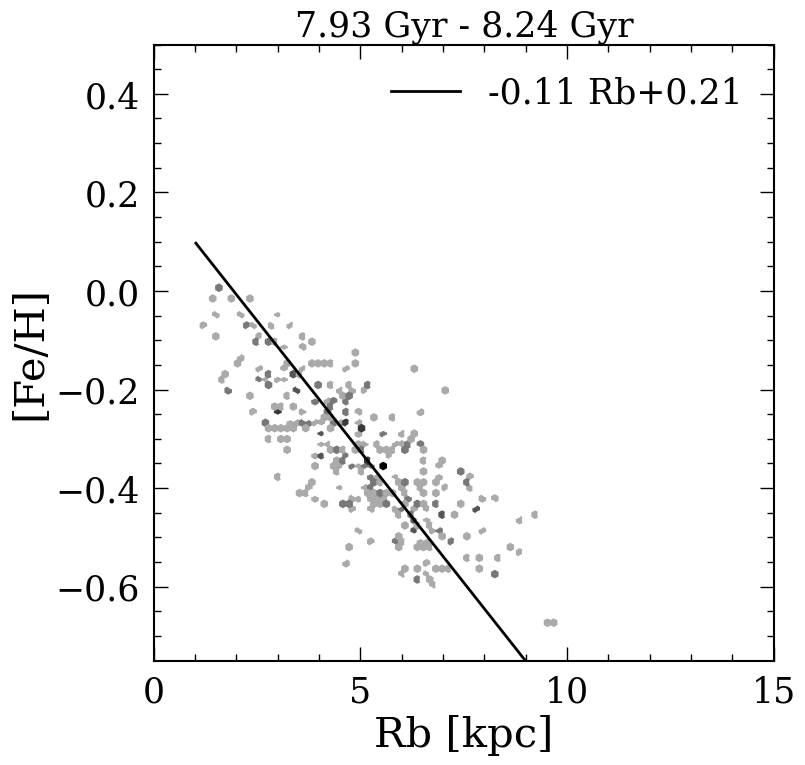

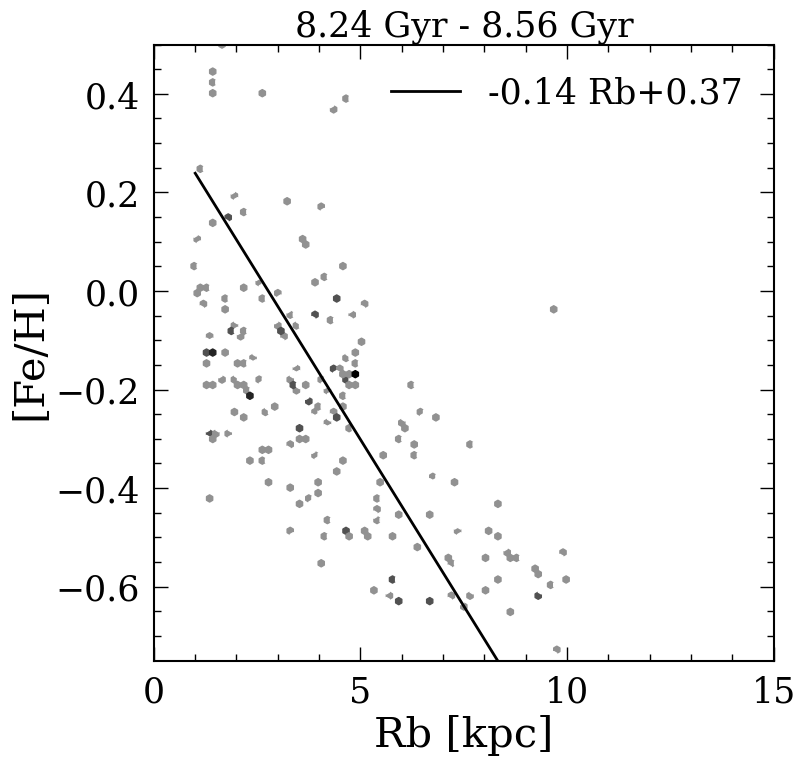

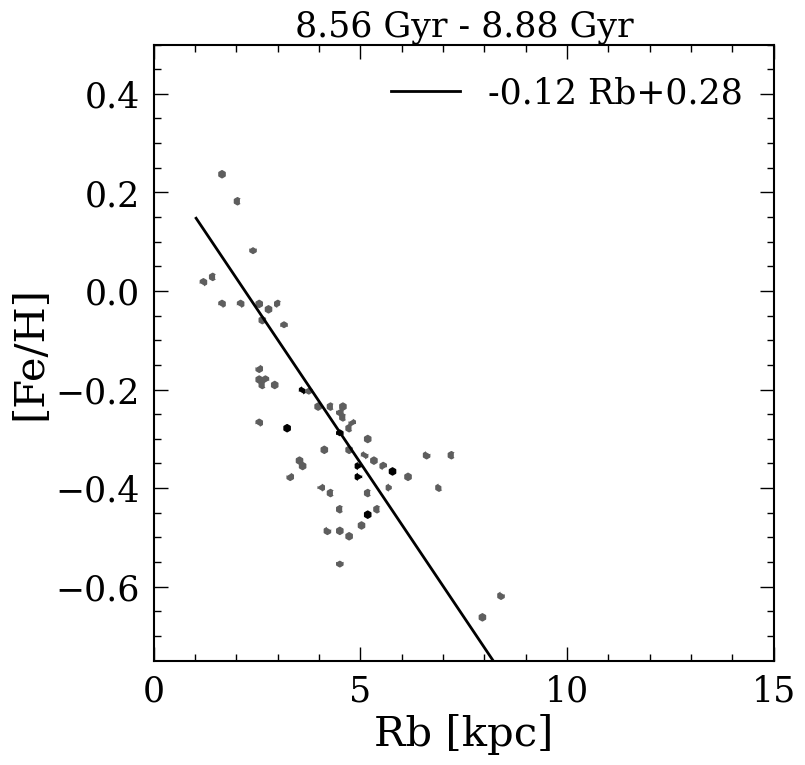

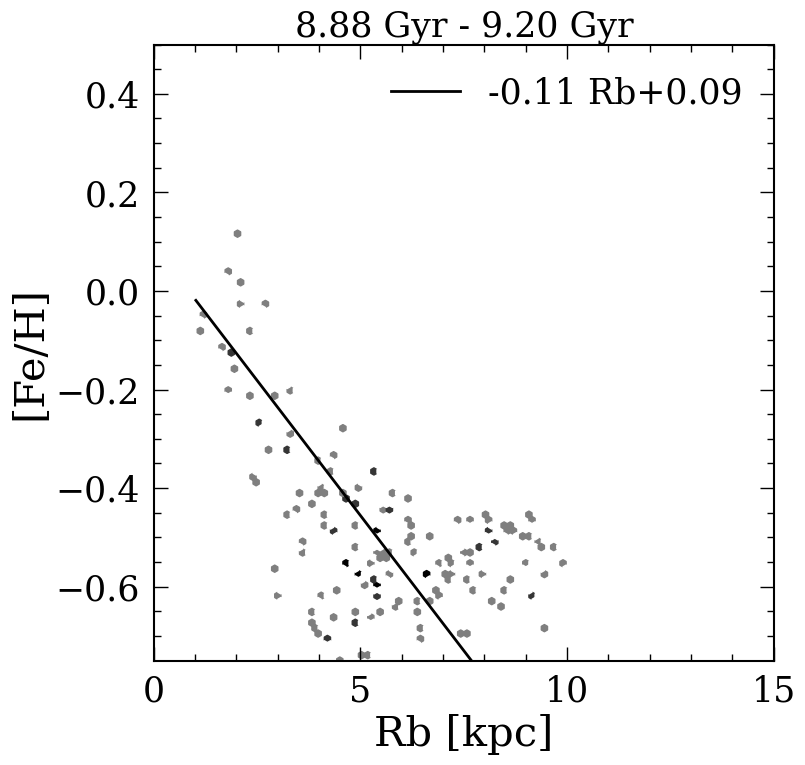

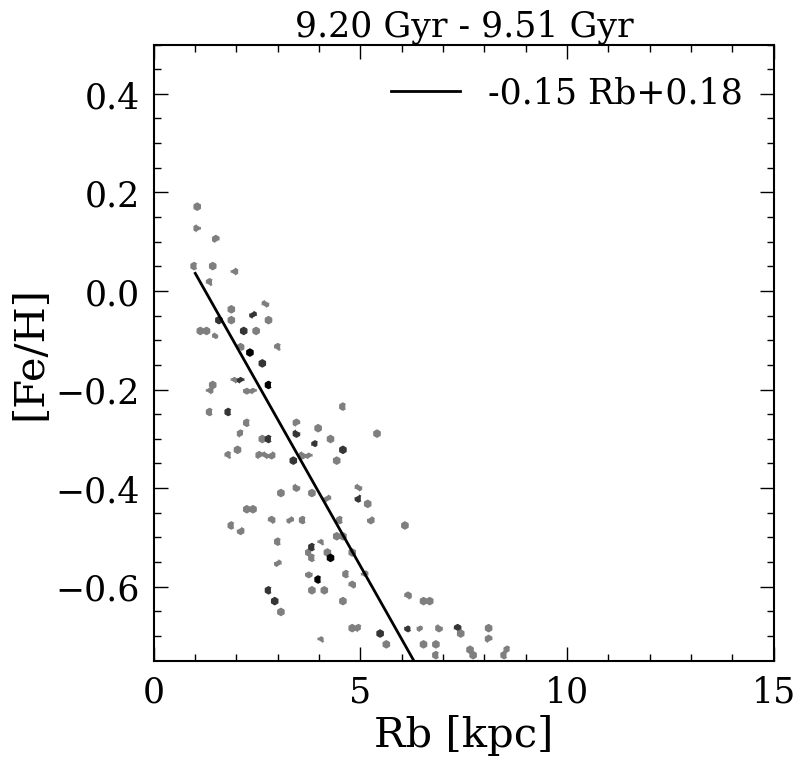

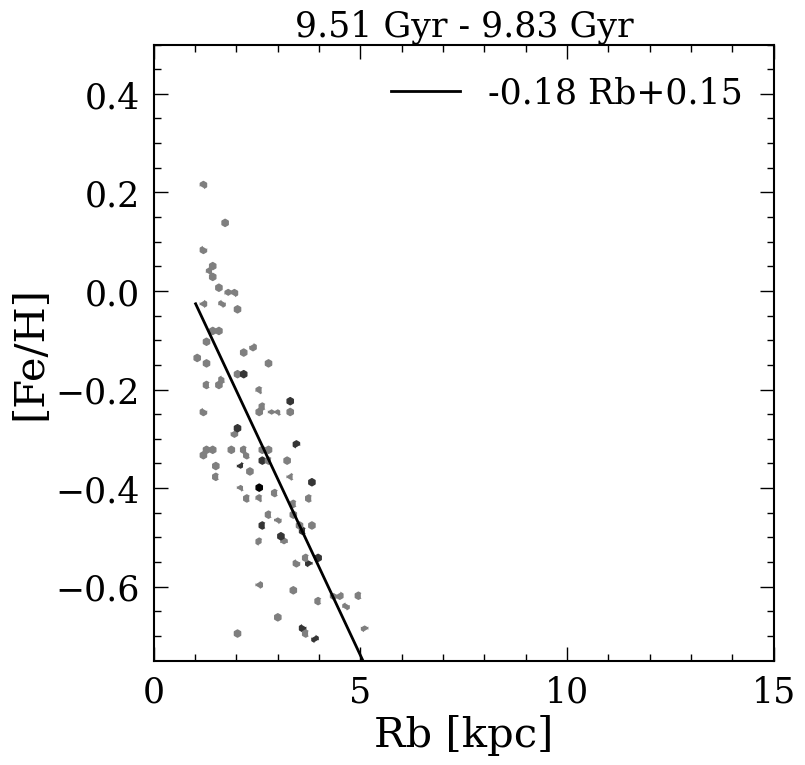

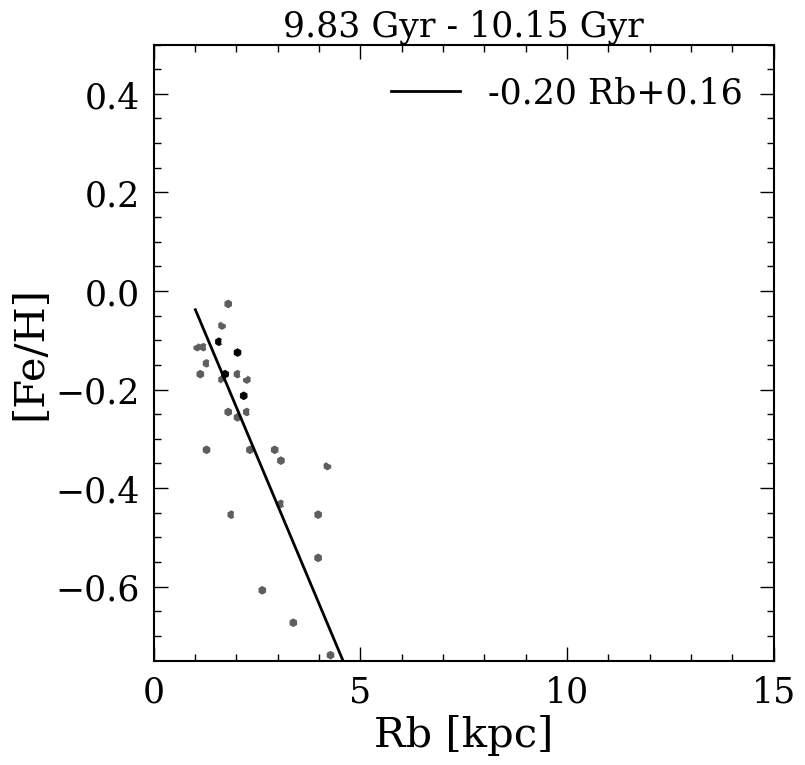

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

In [261]:
disktime = 10
checkdist = 5
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
            
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        feh_sing_fit, r_sing_fit = zip(*sorted(zip(feh_sing[m2], r_sing[m2])))
        r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        feh_sing_fit, r_sing_fit = movingMed_time(feh_sing_fit, r_sing_fit, 0.1, 0.01)
        r_sing_fit, feh_sing_fit = np.array(r_sing_fit), np.array(feh_sing_fit)
        #p = fitpoints(r_sing[m2], feh_sing[m2]) 
        p = fitpoints(r_sing_fit, feh_sing_fit) 
        slopes[i] = p[1]
        
        m3 = abs(r_sing[m2]-checkdist)<0.2
        if sum(m3)<50:
            fehscatter[i] = np.nan
        else:
            fehscatter[i] = np.std(feh_sing[m2][m3]-p(r_sing[m2][m3]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.hexbin(r_sing[m2], feh_sing[m2],extent=(0,15,-0.75,0.5), bins='log',
                      cmap='binary')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            #plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            #plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            #plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            #plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            plt.xlim([0,15])
            plt.ylim([-0.75,0.5])
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            plt.savefig(str(len(agebin)-1-i)+'.png')

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter




def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True,rrange_feh=[7,10]):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


#m = (data['R']>6)&(data['R']<11)
m = (data['feh']>-2)
m = m&(abs(data['ecc'])<0.1)
#m = m&(data['ecc']<0.2)

data_calc = data[m].reset_index(drop=True)

age_calc = np.linspace(0,13,14*3)
slopes_arr = np.zeros((len(age_calc)-1, 2))
fehscatter_arr = np.zeros((len(age_calc)-1, 2))

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=age_calc,
                                                 xlims=[1,10])

for i in trange(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    #data_calc['R_new'] = data_calc['R']
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes_arr[:,i], fehscatter_arr[:,i] = monoage_line_range(data_calc['feh_new'].values, 
                                            data_calc['R'].values, 
                                            data_calc['age_new'].values,
                                            agebin=age_calc,
                                            xlims=[5,7],plotlegend=False)





In [262]:
slopes = [np.mean(slopes_arr[i,:]) for i in range(len(age_calc)-1)]
slopes_err = [np.std(slopes_arr[i,:]) for i in range(len(age_calc)-1)]

fehscatter = [np.mean(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]
fehscatter_err = [np.std(fehscatter_arr[i,:]) for i in range(len(age_calc)-1)]




In [263]:
#fehscatter_f, slopes_rbir

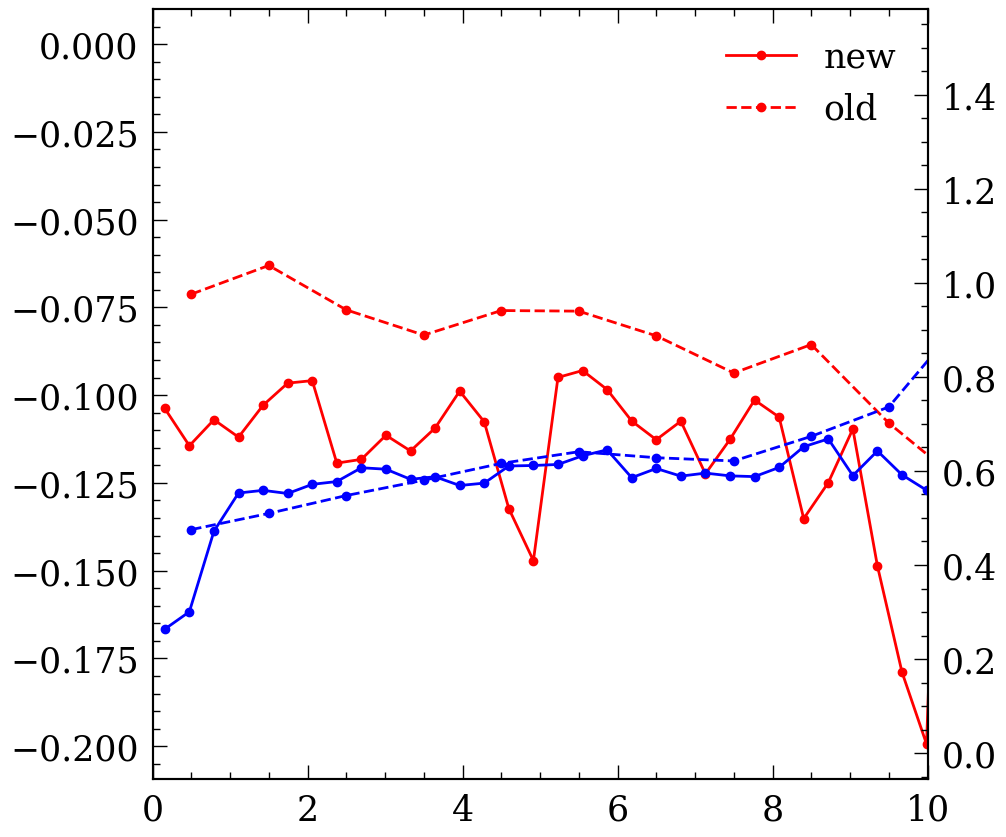

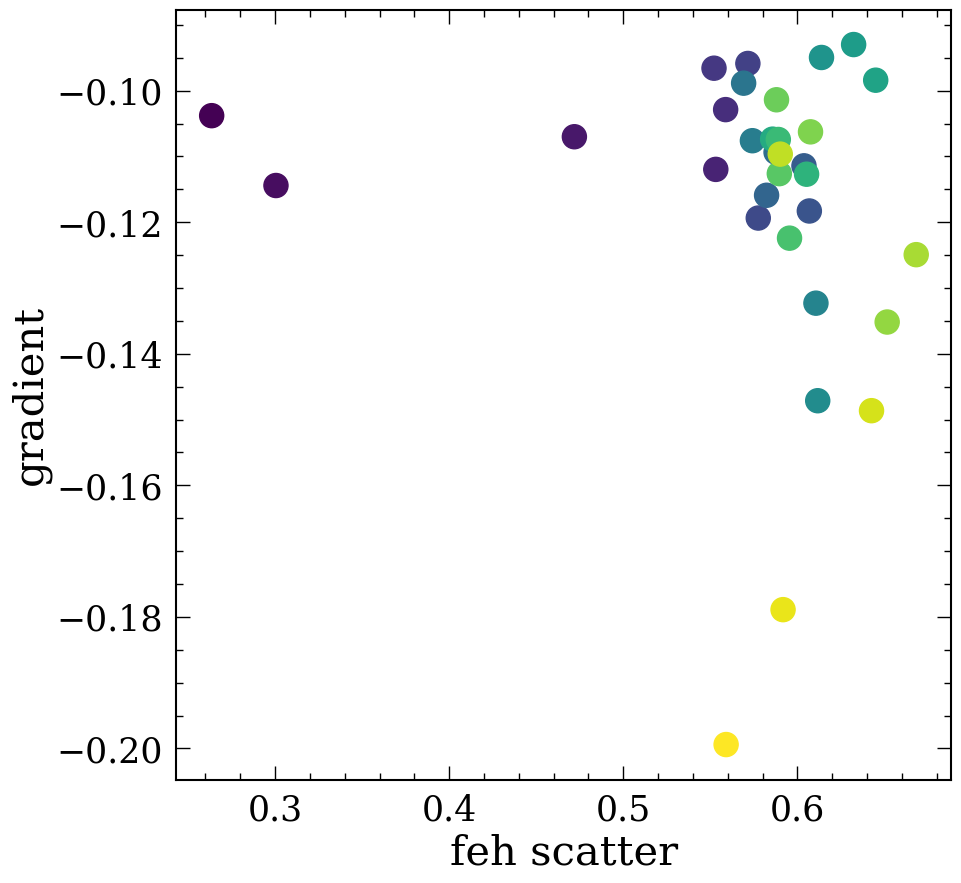

In [264]:
df_org = pd.read_csv('HESTIA.csv')
m = (ages<disktime)

plt.plot(ages, slopes_rbir, 'r-o',label='new')
plt.plot(df_org['age'], df_org['slopes_rbir'], 'r--o',label='old')
plt.legend()
plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
plt.plot(df_org['age'], df_org['fehscatter'], 'b--o')
plt.xlim([0,disktime])

plt.figure()
plt.scatter(np.array(fehscatter)[m], np.array(slopes_rbir)[m], c=np.array(ages)[m], s=300)
plt.xlabel('feh scatter')
plt.ylabel('gradient')
#p = fitpoints(fehscatter, slopes_rbir)
#print(np.mean(abs((slopes_rbir-p(fehscatter))/slopes_rbir)))



pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('HESTIA_update.csv', 
                                                index=False)

In [265]:
def getRb(age, feh, func_m, func_b, fehoffset=0):
    """slopefeh = pd.read_csv('g2.79e12_fehscatter_simdata_inf.csv')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['sloperb_inf'].values,
                     kind='linear')
    
    func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')
    
    func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')"""
    
    Rb = np.zeros(len(age))
    for i in trange(len(age)):
        try:
            m = func_m(age[i])
            b = func_b(age[i])
            Rb[i] = (feh[i]-b)/m
        except:
            Rb[i] = np.nan
    return Rb



In [266]:
m = (data['R']<4)

allages = data['age'].values
allfehs = data['feh'].values
allofes = data['afe'].values

data['age_new'] = [np.random.normal(i, 0.32, 1) for i in allages]
data['feh_new'] = [np.random.normal(i, 0.03, 1) for i in allfehs]
data['ofe_new'] = [np.random.normal(i, 0.03, 1) for i in allofes]

/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_54220/2741936424.py:19: RuntimeWarning: invalid value encountered in log
  feh0[1:][(agebin[1:]/2+agebin[:-1]/2)<13]=np.log(12-(agebin[1:]/2+agebin[:-1]/2)[(agebin[1:]/2+agebin[:-1]/2)<13])/5-1


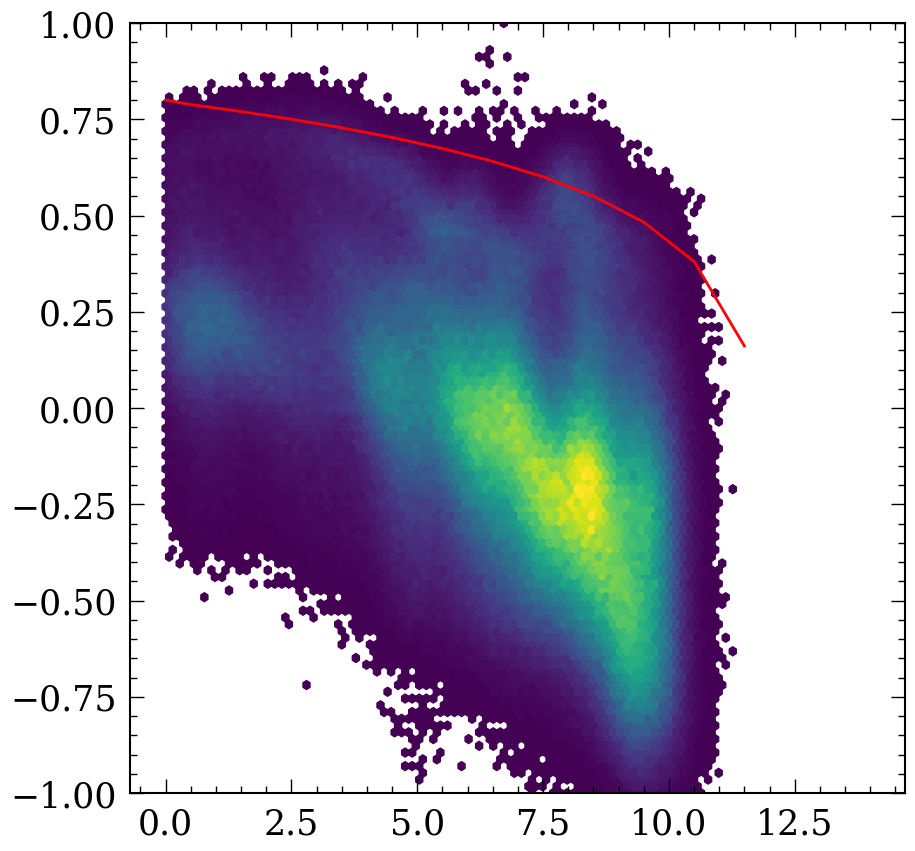

In [267]:
data = data.loc[data['feh']>-1]
#data = data.loc[data['feh']<0.5]
#data_in = (data[(data['R']>7)&(data['R']<10)].reset_index(drop=True))[['age_new','feh_new']].reset_index(drop=True)
data_in = (data[(data['R']<4)].reset_index(drop=True))[['age_new','feh_new']].reset_index(drop=True)
agebin = np.linspace(0,13,14)
feh0 = np.zeros(len(agebin))

"""for i in trange(len(agebin)-1):
    m2 = (data_in['age_new']>agebin[i])&(data_in['age_new']<agebin[i+1])
    feh0[i+1] = np.percentile(data_in['feh_new'][m2], 95)"""

plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,14,-1,1),
          mincnt=1)

#feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2] = feh0[np.append([0], agebin[1:]/2+agebin[:-1]/2)>2]+0.1
#feh0 = feh0+0.1
feh0[0] = 0.8
#feh0[1:] = feh0[1:]+0.2
feh0[1:][(agebin[1:]/2+agebin[:-1]/2)<13]=np.log(12-(agebin[1:]/2+agebin[:-1]/2)[(agebin[1:]/2+agebin[:-1]/2)<13])/5-1
feh0[1:][(agebin[1:]/2+agebin[:-1]/2)<13]=feh0[1:][(agebin[1:]/2+agebin[:-1]/2)<13]+1.3


#feh0[0] = 0.35

#feh0

plt.ylim([-1,1])
plt.plot(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0, 'r-')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


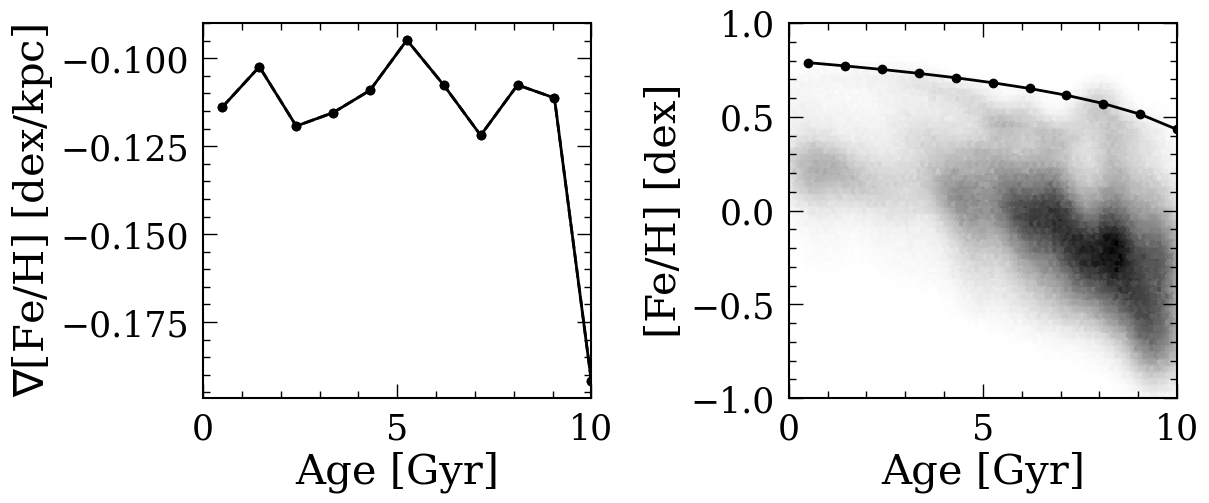

In [275]:
#slopefeh = pd.read_csv('g7.55e11_fehscatter_simdata.csv')
#slopefeh = pd.read_csv('HESTIA.csv')
slopefeh = pd.read_csv('HESTIA_update.csv')



slopefeh = slopefeh.loc[slopefeh['age']<=disktime+0.8]
x = slopefeh['slopes_rbir']
slopefeh = slopefeh.dropna(subset=['fehscatter'])
slopefeh['fehscatter'] = (slopefeh['fehscatter']-min(slopefeh['fehscatter']))/(max(slopefeh['fehscatter'])-min(slopefeh['fehscatter']))
p = fitpoints(slopefeh['fehscatter'], x)
multfac = 0.9
realsope = -0.013
slopefeh['sloperb_inf'] = (p(slopefeh['fehscatter']))*multfac+realsope

func_m_true = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')

func_m = interp1d(slopefeh['age'].values, 
                      slopefeh['slopes_rbir'].values,
                     kind='linear')

func_b = interp1d(np.append([0], agebin[1:]/2+agebin[:-1]/2), feh0,
                     kind='linear')


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0.5,disktime,11), func_m(np.linspace(0.5,disktime,11)), 'k--o',
        label='Inferred')
plt.plot(np.linspace(0.5,disktime,11), func_m_true(np.linspace(0.5,disktime,11)), 'k-o',
        label='True')
plt.xlabel('Age [Gyr]')
plt.ylabel('$\\nabla$[Fe/H] [dex/kpc]')
plt.xlim([0,disktime])

plt.subplot(1,2,2)
plt.hexbin(data_in['age_new'], data_in['feh_new'], extent=(0,disktime,-1,1),
          mincnt=1, cmap='binary')
plt.plot(np.linspace(0.5,disktime,11), func_b(np.linspace(0.5,disktime,11)), 'k-o')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.legend()
plt.tight_layout()

plt.xlim([0,disktime])
plt.ylim([-1,1])

plt.savefig('AddFig/Hestia_slopefeh.png',bbox_inches='tight')
plt.savefig('AddFig/highres/Hestia_slopefeh',bbox_inches='tight')
#plt.savefig('AddFig/g755e11_slopefeh.png',bbox_inches='tight')
#plt.savefig('AddFig/highres/g755e11_slopefeh',bbox_inches='tight')





In [276]:
data = data.loc[(data['age']<disktime)]
data = data.reset_index(drop=True)
#data['Rb_inf'] = getRb(data['age'].values, data['feh'].values, func_m, func_b)
#data['Rb_inf'] = getRb(data['age'].values, data['feh'].values, func_m_true, func_b)

In [277]:
data['Rb_inf_new'] = getRb(data['age_new'].values, data['feh_new'].values, func_m, func_b)

  0%|                                               | 0/3321860 [00:00<?, ?it/s]/var/folders/w0/h14c78gj4rs91wsbcjh87y2m0000gn/T/ipykernel_54220/3470025530.py:20: RuntimeWarning: divide by zero encountered in true_divide
  Rb[i] = (feh[i]-b)/m
100%|██████████████████████████████| 3321860/3321860 [00:47<00:00, 69571.88it/s]


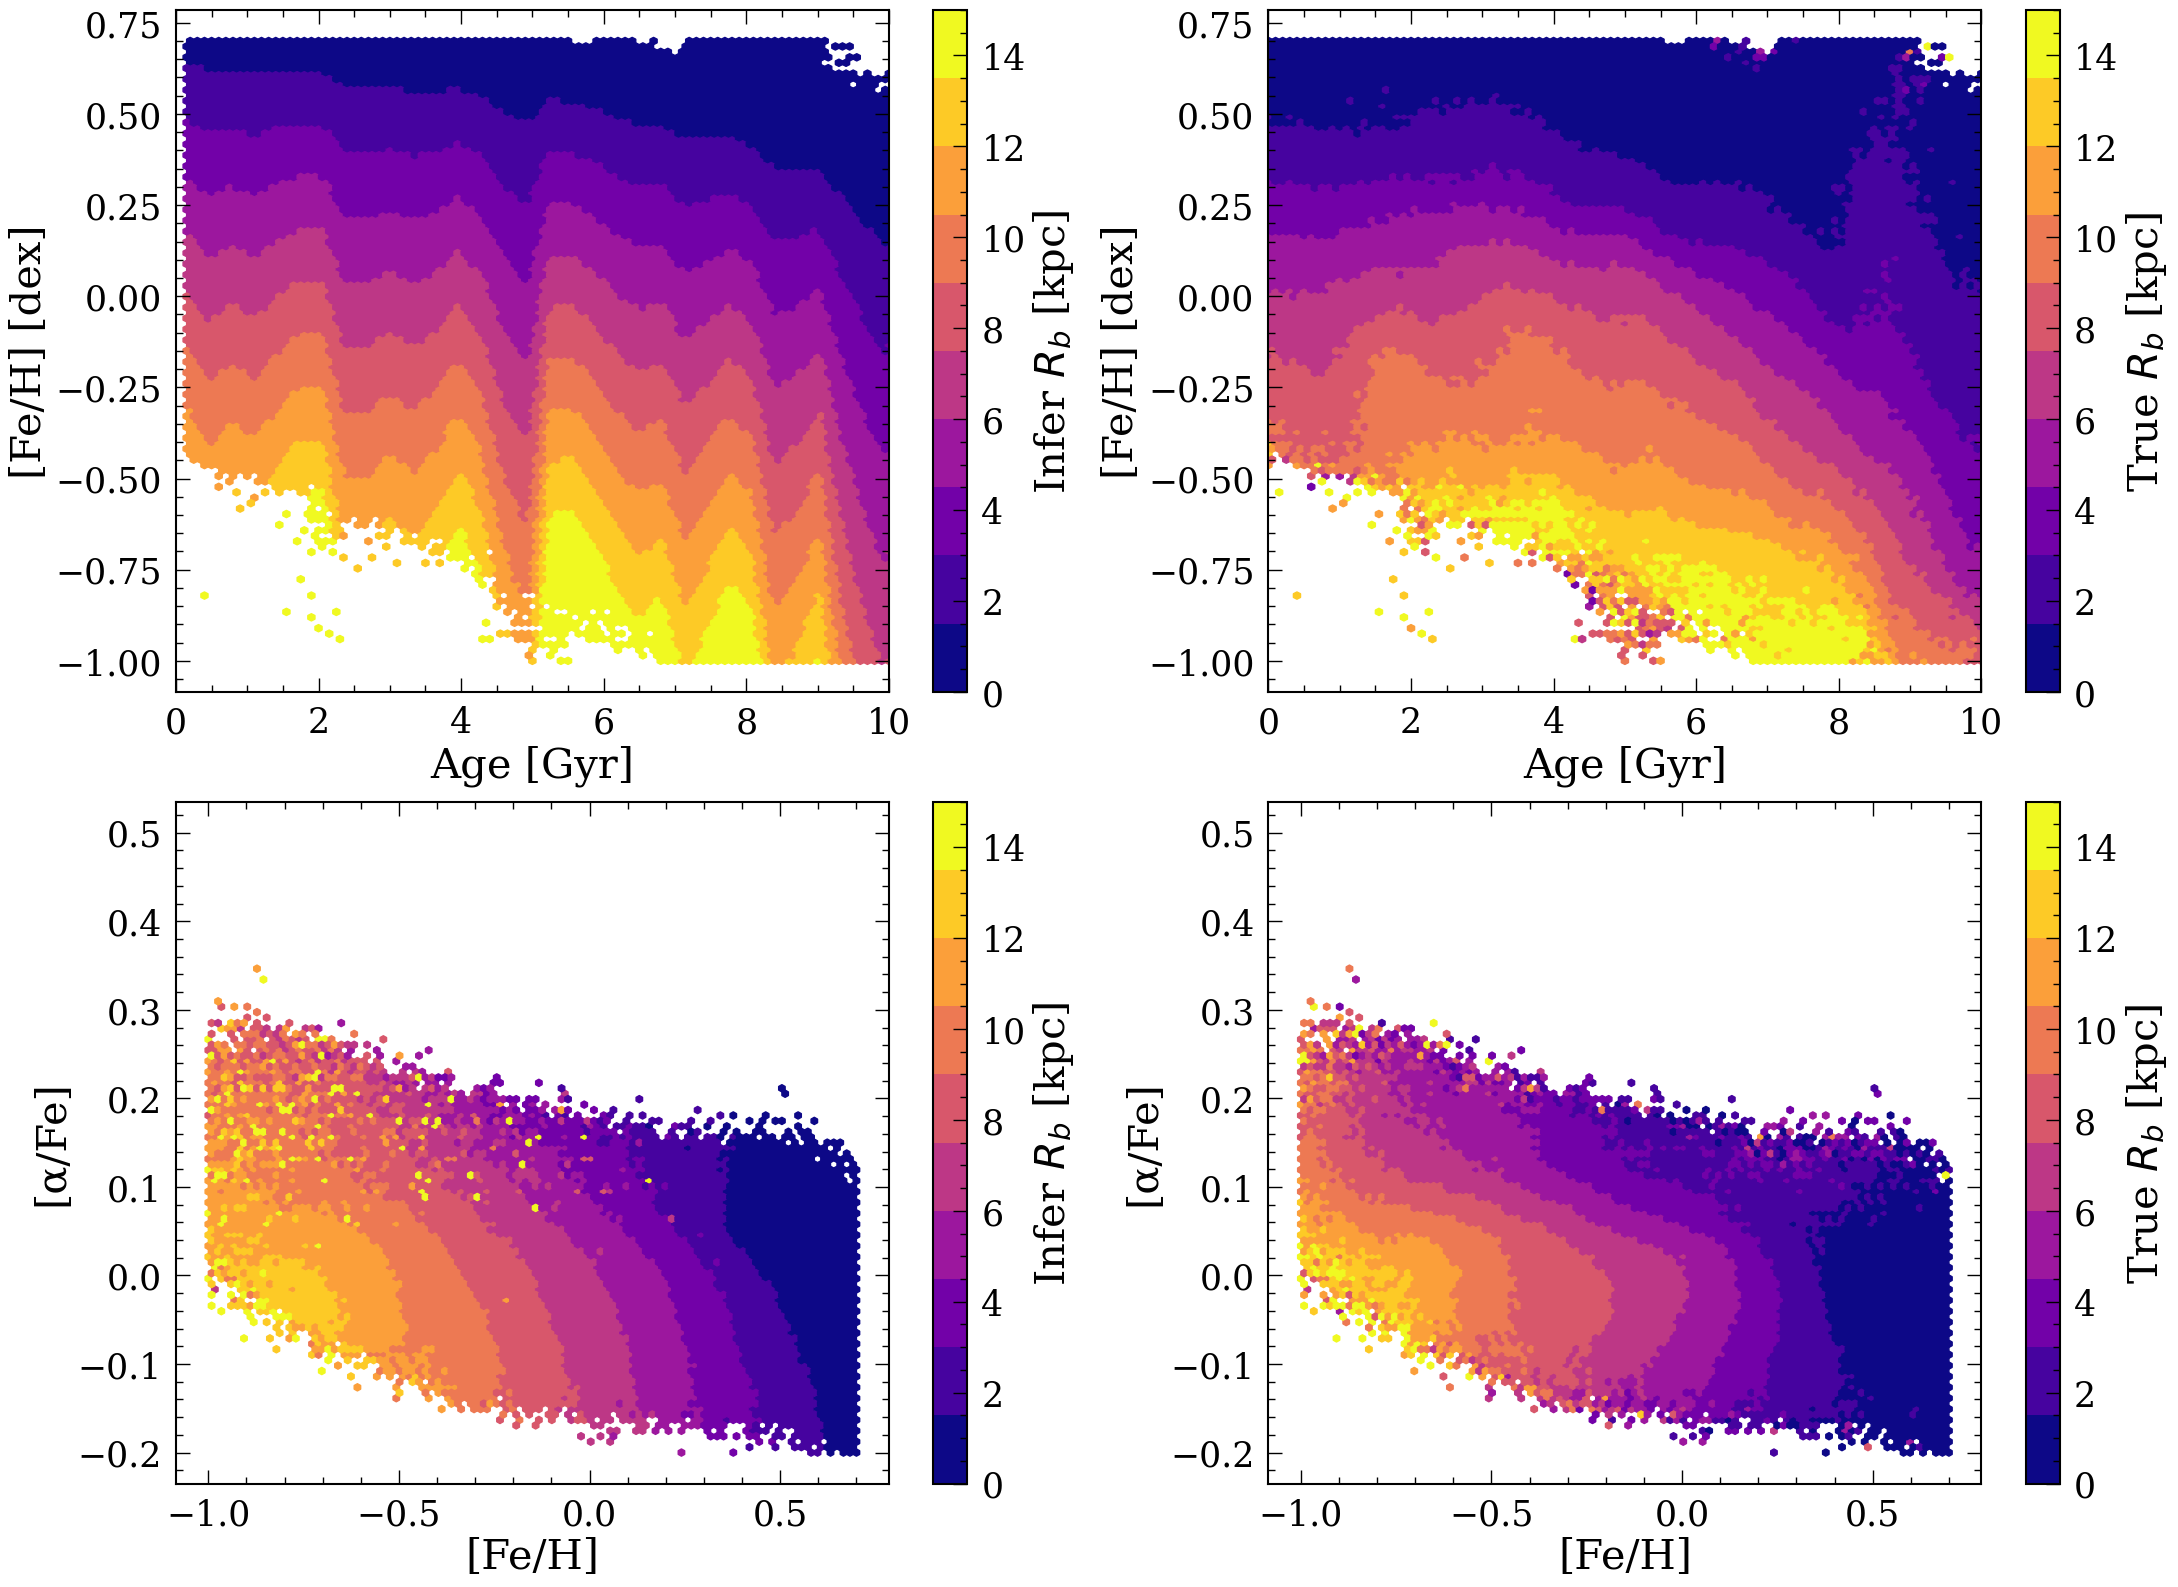

In [278]:
plt.figure(figsize=(22,16))
plt.subplot(2,2,1)
plt.hexbin(data['age_new'],data['feh_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(0,disktime,-1,0.7))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(2,2,2)
plt.hexbin(data['age_new'],data['feh_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(0,disktime,-1,0.7))
plt.colorbar(label='True $R_b$ [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H] [dex]')
plt.xlim([0,disktime])

plt.subplot(2,2,3)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['Rb_inf_new'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(-1,0.7,-0.2,0.5))
plt.colorbar(label='Infer $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,disktime])

plt.subplot(2,2,4)
plt.hexbin(data['feh_new'], data['ofe_new'],C=data['R_bir'],
          cmap=plt.get_cmap('plasma',10),vmin=0,vmax=15,extent=(-1,0.7,-0.2,0.5))
plt.colorbar(label='True $R_b$ [kpc]')
plt.ylabel('[α/Fe]')
plt.xlabel('[Fe/H]')
#plt.xlim([0,0.5])

plt.tight_layout()


plt.savefig('AddFig/Hestia_AMR.png',bbox_inches='tight')
plt.savefig('AddFig/highres/Hestia_AMR',bbox_inches='tight')

#plt.savefig('AddFig/g755e11_AMR.png',bbox_inches='tight')
#plt.savefig('AddFig/highres/g755e11_AMR',bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


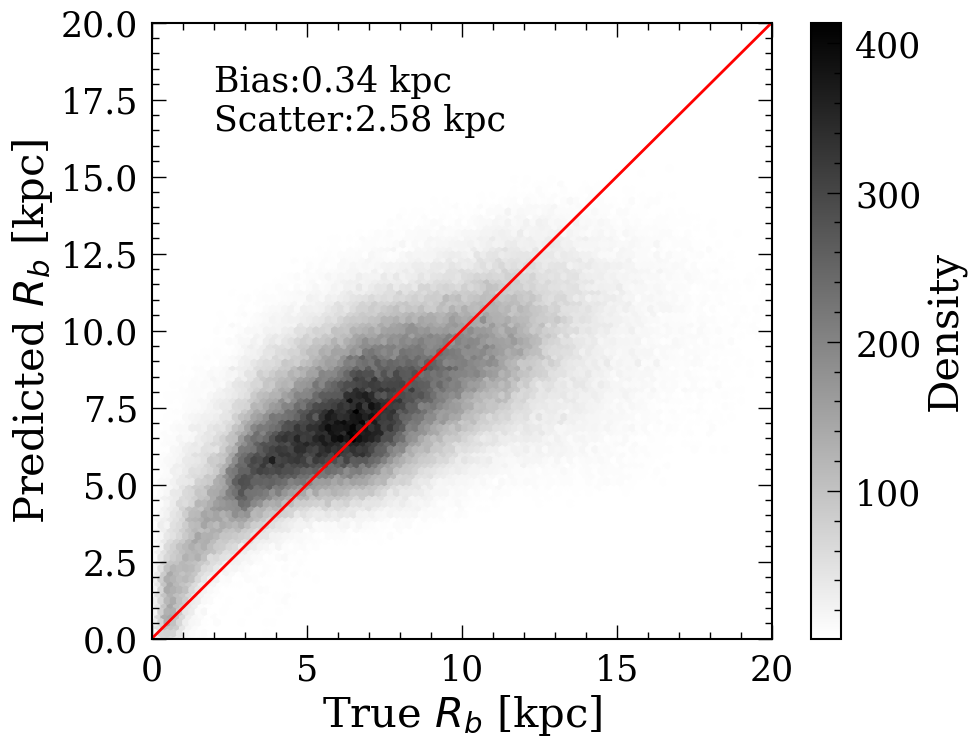

In [279]:
#plt.figure(figsize=(20,8))
#plt.subplot(1,2,1)
pltct = 9
plt.figure(figsize=(10,8))
m_cut = (data['age']<pltct)&(data['ecc']<0.2)
plt.hexbin(data['R_bir'][m_cut], data['Rb_inf_new'][m_cut], cmap='binary',
         mincnt=1, extent=(0,20,0,20))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Density')
plt.text(2,16.5,'Bias:%.2f kpc\nScatter:%.2f kpc'%(abs(np.mean(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut])), np.std(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut])), fontsize=25)

plt.legend(loc=2)


plt.savefig('AddFig/Hestia_test_1.png',bbox_inches='tight')
plt.savefig('AddFig/highres/Hestia_test_1',bbox_inches='tight')

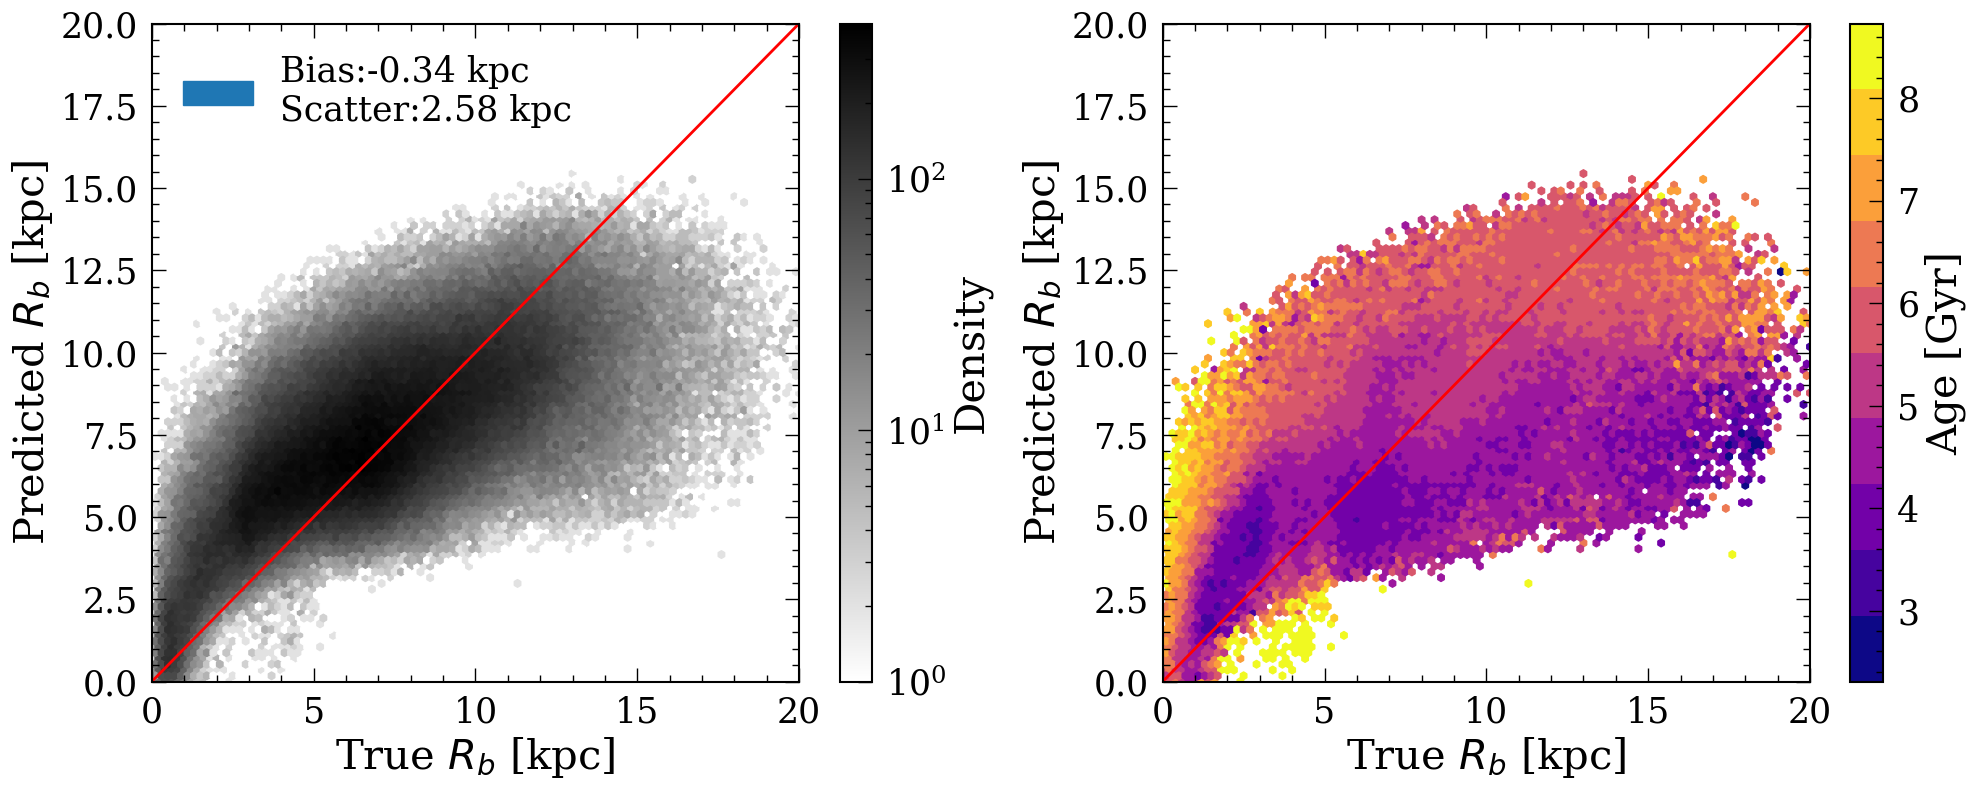

In [280]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
m_cut = (data['age']<pltct)&(data['ecc']<0.2)
#m_cut = (data['age']>3)&((data['age']<6))

plt.hexbin(data['R_bir'][m_cut], data['Rb_inf_new'][m_cut], cmap='binary',
         mincnt=1, extent=(0,20,0,20), bins='log',
          label='Bias:%.2f kpc\nScatter:%.2f kpc'%(np.mean(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut]), np.std(data['R_bir'][m_cut]-data['Rb_inf_new'][m_cut])))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Density')

plt.legend(loc=2)

plt.subplot(1,2,2)
plt.hexbin(data['R_bir'][m_cut], data['Rb_inf_new'][m_cut], 
           C=abs(data['age'][m_cut]),
           cmap=plt.get_cmap('plasma',10),
         mincnt=1, extent=(0,20,0,20))
plt.plot([0,20],[0,20],'r-')
plt.xlabel('True $R_b$ [kpc]')
plt.ylabel('Predicted $R_b$ [kpc]')
plt.xlim([0,20])
plt.ylim([0,20])
plt.colorbar(label='Age [Gyr]')
plt.tight_layout()
